# Etude de cas - Captation de chocs sur les voies d'un tramway

# Descriptions des données 

L'étude de cas porte sur la surveillance des rails de tramways et de métro.

Le client souhaite un système automatique de surveillance des voies, qui lui permette de repérer en quasi temps réel l'apparition ou l'aggravation majeure de défauts des rails pouvant entrainer notamment des risques pour la sécurité des passagers. 

A l'heure actuelle les dispositifs de surveillance sont coûteux (instrumentations lourdes) ou peu fiables (tournées visuelles). L'instrumentation non intrusive vise donc à proposer un dispositif complémentaire à ces tournées en identifiant en amont les zones où les défauts potentiels sont susceptible de se trouver. 

Nous disposons de données récoltées sur une semaine d'expérience de captation de chocs sur les voies d'un tramway d'une grande métropole. 
L'émission de données est en continue, toutes les 5 secondes, sauf en cas d’arrêt prolongé des rames.
Un enregistrement est effectué en cas de détection de choc. Le choc est détecté quand la vibration atteint un certain seuil.

Voici quelques informations essentielles sur la ligne instrumentée :   
	- est une ligne de metro aérien d’une grande capitale  
	- un seul train a été équipé  
	- le train ne change pas de sens  
	- le train circule sur deux tracks dédiés (deux directions possible : PANLAP ou LAPPAN), sans “fourche”.  
	- les données disponibles sont des données du 1er semestre 2021   

In [8]:
#librairies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
#import seaborn as sns
#sns.set_theme()

import time 
import datetime

In [9]:
#Tables
data_path="C:/Users/razan/2023MIS/data"
data_located =pd.read_csv(data_path+"/raw_data/data_shocks_located_3000_first.csv", index_col=3, sep=';')
data_journeys_detail = pd.read_csv(data_path + '/miscellaneous/data_journeys_detail.csv', sep = ";")

## Données des trajets

In [10]:
data_journeys_detail

,id_serie,direction,sub_subseq_start,sub_subseq_end,pk_min,pk_max,nb_points,area,sub_distance,distance,subcoverage
0,2021-02-01_00:25:00-00:51:10,PANLAP,2021-02-01 00:25:00.022,2021-02-01 00:29:10.020,10360.805360,11699.673374,19,_002,134.025470,1559.000000,0.085969
1,2021-02-01_00:25:00-00:51:10,PANLAP,2021-02-01 00:29:30.022,2021-02-01 00:31:05.021,11892.421504,12972.885931,19,_003,1131.578496,1243.000000,0.910361
2,2021-02-01_00:25:00-00:51:10,PANLAP,2021-02-01 00:31:10.019,2021-02-01 00:33:10.019,13043.234435,14482.103059,21,_004,1326.939508,1606.000000,0.826239
3,2021-02-01_00:25:00-00:51:10,PANLAP,2021-02-01 00:33:30.020,2021-02-01 00:35:10.019,14739.138865,15805.048502,20,_005,1065.909637,1311.000000,0.813051
4,2021-02-01_00:25:00-00:51:10,PANLAP,2021-02-01 00:35:30.021,2021-02-01 00:38:10.017,16041.106610,18279.755237,29,_006,1878.975740,2356.000000,0.797528
...,...,...,...,...,...,...,...,...,...,...,...
48756,2021-07-22_23:11:51-23:38:51,LAPPAN,2021-07-22 23:19:51.017,2021-07-22 23:24:06.016,18348.305195,19808.073443,44,_007,1289.712670,1529.000000,0.843501
48757,2021-07-22_23:11:51-23:38:51,LAPPAN,2021-07-22 23:18:06.017,2021-07-22 23:19:46.017,19883.728224,20992.005237,11,_008,510.863991,1250.000000,0.408691
48758,2021-07-22_23:11:51-23:38:51,LAPPAN,2021-07-22 23:15:26.014,2021-07-22 23:18:01.017,21090.923887,22955.548596,29,_009,1715.659863,1933.000000,0.887563
48759,2021-07-22_23:11:51-23:38:51,LAPPAN,2021-07-22 23:12:06.015,2021-07-22 23:15:21.014,23040.657940,25100.873221,31,_010,1648.543679,2106.000000,0.782784


Ce premier jeu de données de taille 48 761 observations et 11 variables ne comportent pas de valeurs manquantes.
Dans cette table on y trouve pour chaque portion de trajet effectuée par un tramway, la date et l'heure de départ, la direction du tramway, la date et l'heure du début de de la fin de la portion enregistrée (5 secondes environ).
Cette portion enregistre le numéro de la station, la distance effectuée, le minimum et le maximum des points kilométriques, le rapport entre la distance parcourue et celle enregistrée, 'subcoverage'.


<AxesSubplot: >

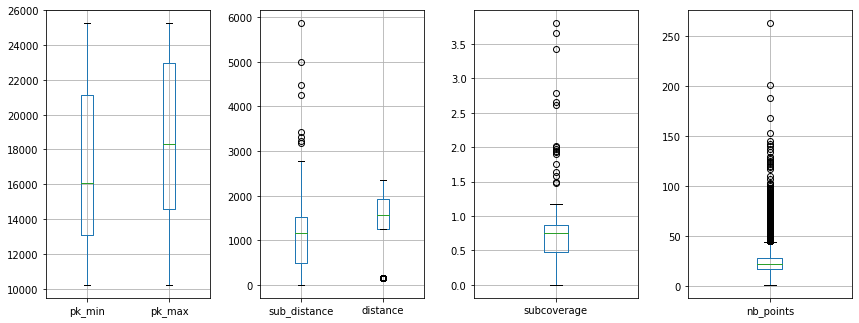

In [11]:
figure = plt.figure(figsize = (14, 5))
plt.gcf().subplots_adjust(left = 0.1, bottom = 0.1,
                       right = 0.9, top = 0.9, wspace = 0.3, hspace = 0.1)
axes = figure.add_subplot(1, 4, 1)
data_journeys_detail.boxplot(column=['pk_min','pk_max'])
axes = figure.add_subplot(1, 4, 2)
data_journeys_detail.boxplot(column=['sub_distance','distance'])
axes = figure.add_subplot(1, 4, 3)
data_journeys_detail.boxplot(column=['subcoverage'])
axes = figure.add_subplot(1, 4, 4)
data_journeys_detail.boxplot(column=['nb_points'])

In [12]:
data_journeys_detail.describe(include="float64").transpose()

,count,mean,std,min,25%,50%,75%,max
pk_min,48761.0,17310.165712,4695.605532,10223.001931,13064.208598,16093.573204,21112.457418,25264.950502
pk_max,48761.0,18684.535719,4623.466960,10237.768796,14583.843541,18294.827997,22959.216529,25265.993118
sub_distance,48761.0,1050.195651,603.228492,0.000000,485.169297,1167.756651,1511.373205,5866.314502
distance,48761.0,1512.295310,564.333498,163.025851,1250.000000,1559.000000,1933.000000,2356.000000
subcoverage,48761.0,0.672357,0.272373,0.000000,0.471934,0.759122,0.864151,3.801758


### Données GPS

In [13]:
data_gps

,timestamp,sensor,pk,timestamp_dt,id_serie,direction,nearest_pk,speed_prec,speed_next
0,1617235275019,XXX_3,10245.018825,2021-04-01 00:01:15.019,2021-04-01 00:01:10.020,PANLAP,10245.28,3.740910,5.880716
1,1617235280020,XXX_3,10253.188120,2021-04-01 00:01:20.020,2021-04-01 00:01:10.020,PANLAP,10255.28,5.880716,6.445588
2,1617235285020,XXX_3,10262.140325,2021-04-01 00:01:25.020,2021-04-01 00:01:10.020,PANLAP,10265.28,6.445588,7.063472
3,1617235290020,XXX_3,10271.950702,2021-04-01 00:01:30.020,2021-04-01 00:01:10.020,PANLAP,10275.28,7.063472,5.232628
4,1617235295020,XXX_3,10279.218242,2021-04-01 00:01:35.020,2021-04-01 00:01:10.020,PANLAP,10275.28,5.232628,3.760407
...,...,...,...,...,...,...,...,...,...
583779,1625055538022,XXX_3,23655.005060,2021-06-30 12:18:58.022,2021-06-30 12:18:53.022,LAPPAN,23655.13,60.276973,NaN
583780,1625055558023,XXX_3,23370.757261,2021-06-30 12:19:18.023,2021-06-30 12:19:13.022,LAPPAN,23375.13,47.277533,NaN
583781,1625055578022,XXX_3,23197.077074,2021-06-30 12:19:38.022,2021-06-30 12:19:33.021,LAPPAN,23195.13,19.900385,NaN
583782,1625055618022,XXX_3,23166.869811,2021-06-30 12:20:18.022,2021-06-30 12:20:13.022,LAPPAN,23165.13,1.042909,NaN


In [14]:
data_gps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583784 entries, 0 to 583783
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   timestamp     583784 non-null  int64  
 1   sensor        583784 non-null  object 
 2   pk            583784 non-null  float64
 3   timestamp_dt  583784 non-null  object 
 4   id_serie      583784 non-null  object 
 5   direction     583784 non-null  object 
 6   nearest_pk    583784 non-null  float64
 7   speed_prec    583784 non-null  float64
 8   speed_next    544571 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 40.1+ MB


In [15]:
print(f"La variable 'speed_next' contient {100*(583784-544571)/583784:.2f} % de valeurs manquantes.")

La variable 'speed_next' contient 6.72 % de valeurs manquantes.


La table de données GPS est composée de 9 variables et 583 784 observations. Nous disposons de 4 variables de type 'object', 4 variables de type 'float' et une variable de type 'int'.

### Analyse des variables

In [16]:
# Variables de type 'object'

print('Valeurs de la variable \'sensor\':', data_gps.sensor.value_counts()) 
print('Valeurs de la variable \'timestamp_dt\':', data_gps.timestamp_dt.value_counts()) 
print('Valeurs de la variable \'id_serie\':', data_gps.id_serie.value_counts()) 
print('Valeurs de la variable \'direction\':', data_gps.direction.value_counts()) 

Valeurs de la variable 'sensor': XXX_3    583784
Name: sensor, dtype: int64
Valeurs de la variable 'timestamp_dt': 2021-04-01 00:01:15.019    1
2021-05-31 22:08:45.023    1
2021-05-31 22:08:15.022    1
2021-05-31 22:08:20.023    1
2021-05-31 22:08:25.023    1
                          ..
2021-04-28 23:03:22.019    1
2021-04-28 23:03:17.019    1
2021-04-28 23:03:12.019    1
2021-04-28 23:03:07.019    1
2021-06-30 12:20:58.023    1
Name: timestamp_dt, Length: 583784, dtype: int64
Valeurs de la variable 'id_serie': 2021-05-09 12:19:05.018    281
2021-04-03 23:13:09.018    269
2021-04-12 20:01:45.017    239
2021-04-03 14:10:50.019    234
2021-04-05 10:08:41.021    232
                          ... 
2021-04-30 01:38:13.018      1
2021-04-30 01:22:43.019      1
2021-04-30 01:18:33.017      1
2021-04-30 01:17:18.017      1
2021-06-30 12:20:53.023      1
Name: id_serie, Length: 35200, dtype: int64
Valeurs de la variable 'direction': PANLAP    302662
LAPPAN    281122
Name: direction, dtype: int

La variable 'sensor' est l'identifiant du capteur GPS, elle peut être négligée dans cette table car toutes les observations ont été enregistrées avec ce même capteur GPS.  
La variable 'timestamp_dt' est une variable temporelle correspondant à la date et heure de chaque enregistrement et donc à peu près tous les 5 secondes.  
La variable 'id_serie' est une variable temporelle également. Elle contient des valeurs dupliquées.  
Pour finir nous avons la variable 'direction' qui indique le sens du trajet. Il y a deux choix possibles: direction PANLAP ou direction LAPPAN.

In [17]:
# Variables de type 'float'

print('Valeurs de la variable \'pk\':', data_gps.pk.value_counts()) 
print('Valeurs de la variable \'nearest_pk\':', data_gps.nearest_pk.value_counts()) 
print('Valeurs de la variable \'speed_prec\':', data_gps.speed_prec.value_counts()) 
print('Valeurs de la variable \'speed_next\':', data_gps.speed_next.value_counts()) 

Valeurs de la variable 'pk': 10365.280000    60
10375.130000    58
19975.280000    31
10355.280000    25
25245.280000    21
                ..
24989.867344     1
24624.152280     1
24542.273078     1
24459.022639     1
22670.777278     1
Name: pk, Length: 581966, dtype: int64
Valeurs de la variable 'nearest_pk': 11935.13    8194
14785.13    8128
18455.13    7876
10365.28    7840
16095.13    7583
            ... 
10415.13       1
20505.13       1
11285.13       1
20685.13       1
11485.28       1
Name: nearest_pk, Length: 2800, dtype: int64
Valeurs de la variable 'speed_prec': 0.000000     30
0.093616      2
0.062909      2
7.200000      2
1.270048      1
             ..
0.399357      1
0.506815      1
0.920747      1
0.549890      1
77.592979     1
Name: speed_prec, Length: 583752, dtype: int64
Valeurs de la variable 'speed_next': 0.000000     29
0.093616      2
0.062909      2
11.297639     2
55.711057     1
             ..
0.412412      1
0.582026      1
0.371081      1
0.759022     

La variable 'pk' contient des valeurs non uniques même si cela correspond à des données continues car des points kilométriques sont déja prédéfinis au préalable.  
La variable 'nearest_pk' est construite de la même manière et représente le point de référence le plus proche de la position du GPS.  
Les variables 'speed_next' et 'speed_prec' représentent respectivement la vitesse enregistrée du point kilométrique suivant et précédent.

In [18]:
# Variables de type 'int'

print('Valeurs de la variable \'timestamp\':', data_gps.timestamp.value_counts()) 

Valeurs de la variable 'timestamp': 1617235275019    1
1622498925023    1
1622498895022    1
1622498900023    1
1622498905023    1
                ..
1619651002019    1
1619650997019    1
1619650992019    1
1619650987019    1
1625055658023    1
Name: timestamp, Length: 583784, dtype: int64


La variable 'timestamp' est la seule variable discrète dans notre jeu de données et elle correspond à l'instant de l'enregistrement.

In [19]:
data_gps.describe(include="float64").transpose()

,count,mean,std,min,25%,50%,75%,max
pk,583784.0,17575.654954,4414.369398,10223.285841,13705.668359,17371.609620,21233.510027,25265.993118
nearest_pk,583784.0,17575.673265,4414.426085,10225.130000,13705.130000,17375.130000,21235.130000,25268.750000
speed_prec,583784.0,34.521597,28.243035,0.000000,2.433499,34.838479,59.732193,99.929641
speed_next,544571.0,34.438940,28.430914,0.000000,2.277984,34.349877,59.737663,188.392289


Il ne semble pas avoir de valeurs aberrantes dans les observations de la table de données GPS.

<AxesSubplot: >

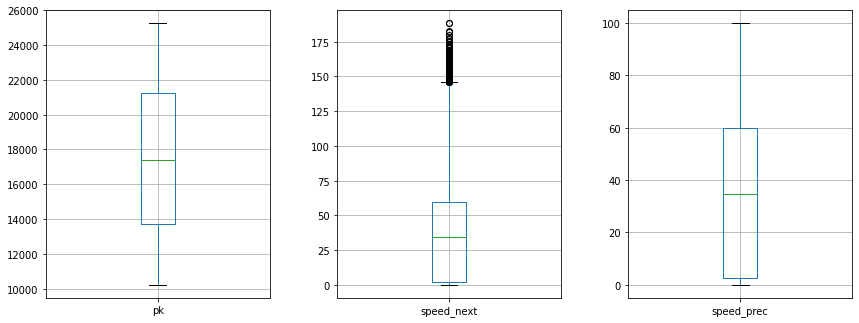

In [20]:
figure = plt.figure(figsize = (14, 5))
plt.gcf().subplots_adjust(left = 0.1, bottom = 0.1,
                       right = 0.9, top = 0.9, wspace = 0.3, hspace = 0.1)
axes = figure.add_subplot(1, 3, 1)
data_gps.boxplot(column=['pk'])
axes = figure.add_subplot(1, 3, 2)
data_gps.boxplot(column=['speed_next'])
axes = figure.add_subplot(1, 3, 3)
data_gps.boxplot(column=['speed_prec'])

### Données de chocs

In [21]:
data_located

,timestamp,pk,sensor,direction,x,y,z,pk_merge_prev,speed_prec_merge_prev,speed_next_merge_prev,pk_merge_next,speed_prec_merge_next,speed_next_merge_next,timeframe_gps_prev,timeframe_gps_next,average_speed_km_h_prev,average_speed_km_h_next
0,1617235693516,12104.077518,XXX_2,PANLAP,"[0.8668750000000001, -0.43312500000000004, 0.0...","[-3.035, -5.535, 0.6649999999999999, -0.835000...","[-1.034375, -0.834375, 0.565625, -1.634375, 2....",12046.108935,46.357203,59.693049,12128.999366,59.693049,NaN,3.496,1.503,59.693049,59.693049
1,1617235693516,12104.077518,XXX_2,PANLAP,"[0.8668750000000001, -0.43312500000000004, 0.0...","[-3.035, -5.535, 0.6649999999999999, -0.835000...","[-1.034375, -0.834375, 0.565625, -1.634375, 2....",12046.108935,46.357203,59.693049,12128.999366,59.693049,NaN,3.496,1.503,59.693049,59.693049
2,1617235693516,12104.077518,XXX_2,PANLAP,"[0.8668750000000001, -0.43312500000000004, 0.0...","[-3.035, -5.535, 0.6649999999999999, -0.835000...","[-1.034375, -0.834375, 0.565625, -1.634375, 2....",12046.108935,46.357203,59.693049,12128.999366,59.693049,NaN,3.496,1.503,59.693049,59.693049
3,1617235693516,12104.077518,XXX_2,PANLAP,"[0.8668750000000001, -0.43312500000000004, 0.0...","[-3.035, -5.535, 0.6649999999999999, -0.835000...","[-1.034375, -0.834375, 0.565625, -1.634375, 2....",12046.108935,46.357203,59.693049,12128.999366,59.693049,NaN,3.496,1.503,59.693049,59.693049
4,1617235799669,13361.726185,XXX_2,PANLAP,"[0.78625, 0.38625000000000004, -0.41375, 0.286...","[-1.888125, 1.511875, 0.511875, 2.411875, 1.81...","[0.360625, -0.439375, -0.5393749999999999, 0.2...",13284.642900,45.003917,59.690218,13367.579143,59.690218,68.533889,4.649,0.353,59.690218,59.690218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1617666408598,23543.877808,XXX_2,PANLAP,"[-1.084375, 0.415625, 0.315625, -0.984375, 0.9...","[-1.50875, -3.7087499999999998, -3.80875, -2.3...","[0.698125, 1.298125, 1.298125, -0.501875, -1.8...",23531.074722,73.612509,79.604681,23641.636778,79.604681,84.276015,0.579,4.421,79.604681,79.604681
2996,1617666408768,23547.636918,XXX_1,PANLAP,"[-0.34125, -0.041249999999999995, 0.55875, -0....","[-4.734375, -5.434375, -2.134375, 0.5656249999...","[0.31124999999999997, 2.11125, 0.41125, -2.288...",23531.074722,73.612509,79.604681,23641.636778,79.604681,84.276015,0.749,4.251,79.604681,79.604681
2997,1617666450296,24518.120466,XXX_2,PANLAP,"[0.985, 1.385, -0.715, -0.915, 0.885, 0.485, 0...","[1.050625, -1.449375, 1.650625, 4.450625000000...","[-1.806875, 1.193125, 0.29312499999999997, -1....",24464.499521,84.543343,84.776199,24582.267790,84.776199,NaN,2.277,2.724,84.776199,84.776199
2998,1617668752278,11620.193952,XXX_1,PANLAP,"[0.266875, 0.06687500000000002, 0.166875000000...","[-0.571875, -0.471875, 2.428125, 1.728125, -0....","[-0.09875, -0.29875, 0.30125, 0.30125, -3.2987...",11615.597809,62.528660,63.638907,11703.985180,63.638907,53.312097,0.260,4.740,63.638907,63.638907


In [22]:
data_located.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                3000 non-null   int64  
 1   pk                       3000 non-null   float64
 2   sensor                   3000 non-null   object 
 3   direction                3000 non-null   object 
 4   x                        3000 non-null   object 
 5   y                        3000 non-null   object 
 6   z                        3000 non-null   object 
 7   pk_merge_prev            3000 non-null   float64
 8   speed_prec_merge_prev    3000 non-null   float64
 9   speed_next_merge_prev    3000 non-null   float64
 10  pk_merge_next            3000 non-null   float64
 11  speed_prec_merge_next    3000 non-null   float64
 12  speed_next_merge_next    2732 non-null   float64
 13  timeframe_gps_prev       3000 non-null   float64
 14  timeframe_gps_next      

In [23]:
print(f"La variable 'speed_next_merge' contient {100*(3000-2732)/3000:.2f} % de valeurs manquantes.")

La variable 'speed_next_merge' contient 8.93 % de valeurs manquantes.


La table de données des chocs est composée de 17 variables et 3000 observations. 
Nous avons 11 variables de type 'float', 1 variable de type 'int' et 5 variables de type 'object'.

### Analyse des variables

In [24]:
# Variables de type 'object'

print('Valeurs de la variable \'x\':')
data_located.x

Valeurs de la variable 'x':


0       [0.8668750000000001, -0.43312500000000004, 0.0...
1       [0.8668750000000001, -0.43312500000000004, 0.0...
2       [0.8668750000000001, -0.43312500000000004, 0.0...
3       [0.8668750000000001, -0.43312500000000004, 0.0...
4       [0.78625, 0.38625000000000004, -0.41375, 0.286...
                              ...                        
2995    [-1.084375, 0.415625, 0.315625, -0.984375, 0.9...
2996    [-0.34125, -0.041249999999999995, 0.55875, -0....
2997    [0.985, 1.385, -0.715, -0.915, 0.885, 0.485, 0...
2998    [0.266875, 0.06687500000000002, 0.166875000000...
2999    [-0.395, -0.195, -0.395, 0.505, 0.305, 0.405, ...
Name: x, Length: 3000, dtype: object

Les variables 'x', 'y' et 'z' correspondent aux positions des accélérations enregistrées par les 2 accéléromètres (avec une fréquence d'échantillonage de 400Hz et un buffer de 80 points). Ces variables doivent être transformées en vecteurs numériques.  
Contrairement au jeu de données précédent, la direction est unique pour toutes les observations: direction PANLAP.

In [25]:
data_located.describe(include="float64").transpose()

,count,mean,std,min,25%,50%,75%,max
pk,3000.0,16884.945285,3639.180137,11603.559162,13641.147836,16611.700745,19163.282111,25122.257962
pk_merge_prev,3000.0,16838.064461,3638.742279,11567.125941,13599.359300,16550.045215,19102.907951,25120.222264
speed_prec_merge_prev,3000.0,66.970730,11.972519,6.903873,59.384810,69.698323,75.094290,90.856734
speed_next_merge_prev,3000.0,69.020333,9.863546,5.333708,59.674090,73.800451,75.584788,90.856734
pk_merge_next,3000.0,16933.924292,3639.763815,11637.962938,13704.456299,16648.267001,19206.442809,25127.631673
speed_prec_merge_next,3000.0,69.020333,9.863546,5.333708,59.674090,73.800451,75.584788,90.856734
speed_next_merge_next,2732.0,68.790062,10.239396,8.726046,59.781855,71.906317,74.848205,91.972477
timeframe_gps_prev,3000.0,2.438827,1.420935,0.007000,1.205000,2.431000,3.648250,4.999000
timeframe_gps_next,3000.0,2.561081,1.420934,0.001000,1.351750,2.569500,3.796000,4.993000
average_speed_km_h_prev,3000.0,69.020333,9.863546,5.333708,59.674090,73.800451,75.584788,90.856734


On remarque que les deux dernières variables 'average_speed_km_h_prev' et 'average_speed_km_h_next' ont les mêmes statistiques descriptives et donc probablement les mêmes observations dans la table.

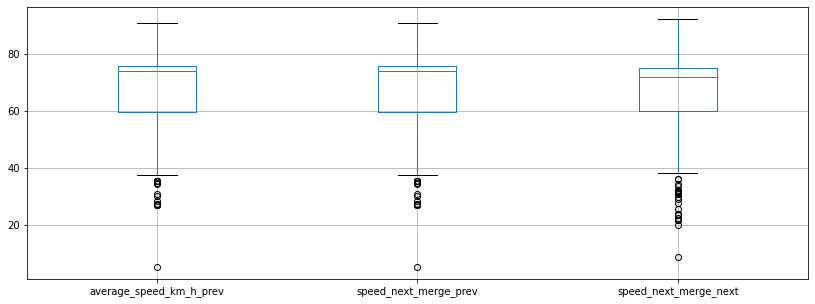

In [26]:
figure = plt.figure(figsize = (14, 5))
boxplot = data_located.boxplot(column=['average_speed_km_h_prev','speed_next_merge_prev','speed_next_merge_next']) 

In [27]:
data_located.corr()

C:\Users\valentin\AppData\Local\Temp\ipykernel_15960\2006538106.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_located.corr()


,timestamp,pk,pk_merge_prev,speed_prec_merge_prev,speed_next_merge_prev,pk_merge_next,speed_prec_merge_next,speed_next_merge_next,timeframe_gps_prev,timeframe_gps_next,average_speed_km_h_prev,average_speed_km_h_next
timestamp,1.000000,-0.011724,-0.012288,0.133121,0.130460,-0.011794,0.130460,0.118923,0.039873,-0.039870,0.130460,0.130460
pk,-0.011724,1.000000,0.999970,0.088361,0.074757,0.999970,0.074757,0.044225,0.008677,-0.008674,0.074757,0.074757
pk_merge_prev,-0.012288,0.999970,1.000000,0.086968,0.072695,0.999993,0.072695,0.041892,0.001164,-0.001161,0.072695,0.072695
speed_prec_merge_prev,0.133121,0.088361,0.086968,1.000000,0.880271,0.090257,0.880271,0.639088,-0.041683,0.041687,0.880271,0.880271
speed_next_merge_prev,0.130460,0.074757,0.072695,0.880271,1.000000,0.076439,1.000000,0.905708,0.031568,-0.031566,1.000000,1.000000
pk_merge_next,-0.011794,0.999970,0.999993,0.090257,0.076439,1.000000,0.076439,0.045402,0.001282,-0.001280,0.076439,0.076439
speed_prec_merge_next,0.130460,0.074757,0.072695,0.880271,1.000000,0.076439,1.000000,0.905708,0.031568,-0.031566,1.000000,1.000000
speed_next_merge_next,0.118923,0.044225,0.041892,0.639088,0.905708,0.045402,0.905708,1.000000,0.092925,-0.092920,0.905708,0.905708
timeframe_gps_prev,0.039873,0.008677,0.001164,-0.041683,0.031568,0.001282,0.031568,0.092925,1.000000,-1.000000,0.031568,0.031568
timeframe_gps_next,-0.039870,-0.008674,-0.001161,0.041687,-0.031566,-0.001280,-0.031566,-0.092920,-1.000000,1.000000,-0.031566,-0.031566


In [ ]:
data_signal.info()

La table de données des signaux, de taille 3000 observations et 5 variables, ne contient pas de valeurs manquantes.  
Elle est composées d'une variable de type 'int' et 4 variables de type 'object'. 
Ces cinq variables sont les mêmes que celles utilisées dans la table précédente. 

### Analyse des observations

In [29]:
data_gps.iloc[1:272,[2,5,6,7,8]]

,pk,direction,nearest_pk,speed_prec,speed_next
1,10253.188120,PANLAP,10255.28,5.880716,6.445588
2,10262.140325,PANLAP,10265.28,6.445588,7.063472
3,10271.950702,PANLAP,10275.28,7.063472,5.232628
4,10279.218242,PANLAP,10275.28,5.232628,3.760407
5,10284.441030,PANLAP,10285.28,3.760407,8.906976
...,...,...,...,...,...
267,25264.810303,PANLAP,25268.75,0.489006,0.654619
268,25265.719496,PANLAP,25268.75,0.654619,2.181526
269,25260.047157,LAPPAN,25255.13,7.628656,6.291195
270,25251.309387,LAPPAN,25255.13,6.291195,5.483355


Le trajet est découpé en plusieurs portions. Tout d'abord la direction 'PAN-LAP' correspondant aux observations 1 à 268, puis la direction LAP-PAN correspondant aux observations 269 à 475. Puis de nouveau la direction 'PAN-LAP' à partir de l'observations 476, etc.

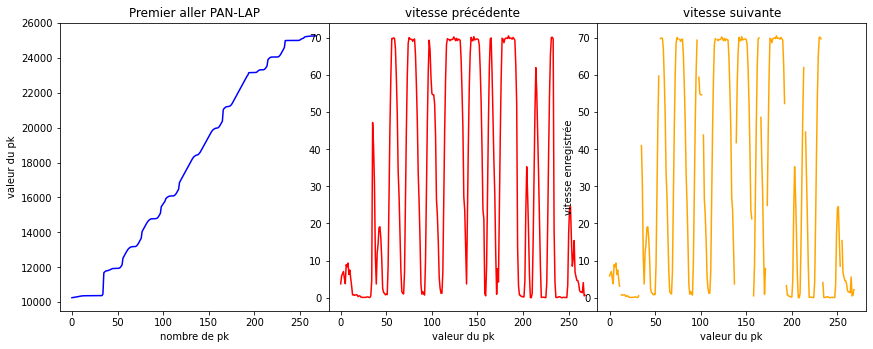

In [30]:
figure = plt.figure(figsize = (14, 5))
plt.gcf().subplots_adjust(left = 0.1, bottom = 0.1,
                       right = 0.9, top = 0.9, wspace = 0, hspace = 0.1)
axes = figure.add_subplot(1, 3, 1)
axes.set_xlabel('nombre de pk')
axes.set_ylabel('valeur du pk')
axes.set_title("Premier aller PAN-LAP")
axes.plot(range(269),data_gps.iloc[0:269,2], color = 'blue')
axes = figure.add_subplot(1, 3, 2)
axes.set_xlabel('valeur du pk')
axes.set_title("vitesse précédente")
axes.plot(range(269), data_gps.iloc[0:269,7], color = 'red')
axes = figure.add_subplot(1, 3, 3)
axes.set_xlabel('valeur du pk')
axes.set_ylabel('vitesse enregistrée')
axes.set_title("vitesse suivante")
axes.plot(range(269), data_gps.iloc[0:269,8], color = 'orange')

Sur ces graphes nous pouvons observer tout d'abord l'évolution des points kilométrique pour le premier aller PAN-LAP, puis la vitesse enregistrée au point précédent et au point suivant. On distingue des coupures auu niveau de la vitesse sur le troisième graphe.

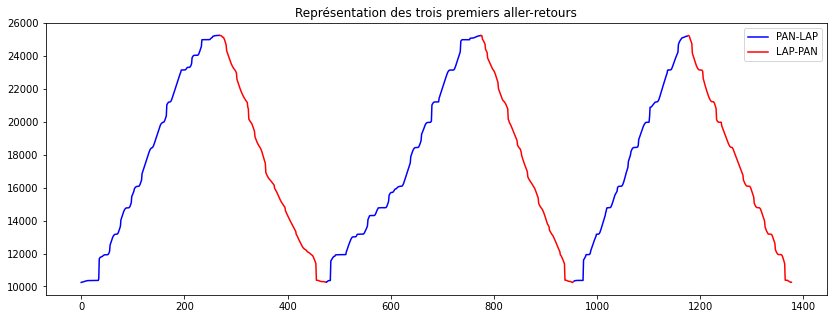

In [31]:
figure = plt.figure(figsize = (14, 5))
plt.plot(data_gps.iloc[0:269,2],color="b",label="PAN-LAP")
plt.plot(data_gps.iloc[269:476,2],color="r",label="LAP-PAN")
plt.plot(data_gps.iloc[476:775,2],color="b")
plt.plot(data_gps.iloc[775:955,2],color="r")
plt.plot(data_gps.iloc[956:1176,2],color="b")
plt.plot(data_gps.iloc[1177:1378,2],color="r")
plt.title("Représentation des trois premiers aller-retours")
plt.legend()

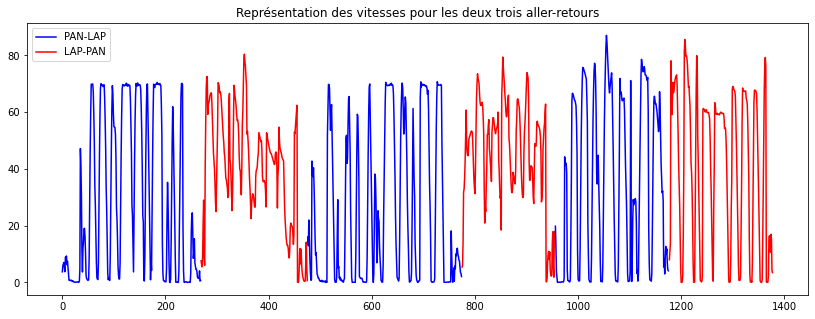

In [32]:
figure = plt.figure(figsize = (14, 5))
plt.plot(data_gps.iloc[0:269,7],color="b",label="PAN-LAP")
plt.plot(data_gps.iloc[269:476,7],color="r",label="LAP-PAN")
plt.plot(data_gps.iloc[476:775,7],color="b")
plt.plot(data_gps.iloc[775:955,7],color="r")
plt.plot(data_gps.iloc[956:1176,7],color="b")
plt.plot(data_gps.iloc[1177:1378,7],color="r")
plt.title("Représentation des vitesses pour les deux trois aller-retours")
plt.legend()

On remarque que les retours paraissent plus courts que les aller, et la vitesse des retours est en moyenne plus rapide.

Text(0.5, 1.0, 'Histogramme des pk estimés pour les données GPS')

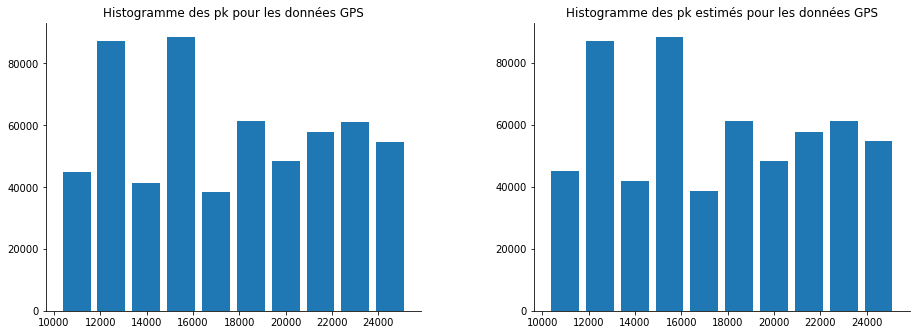

In [33]:
figure = plt.figure(figsize = (15, 5))
plt.gcf().subplots_adjust(left = 0.1, bottom = 0.1,
                       right = 0.9, top = 0.9, wspace = 0.3, hspace = 0.1)
axes = figure.add_subplot(1, 2, 1)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.hist(data_gps.pk, rwidth=0.8)
axes.set_title("Histogramme des pk pour les données GPS")
axes = figure.add_subplot(1,2, 2)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.hist(data_gps.nearest_pk, rwidth=0.8)
axes.set_title("Histogramme des pk estimés pour les données GPS")

La distribution est relativement similaire.

## Clustering

Dans cette partie nous cherchons à effectuer un clustering des points kilométrques à partir des données de chocs. L'objectif est double:  
- Détecter les zones de défauts de voie potentiels
- Distinguer parmi les chocs lesquels sont du bruit et lesquels sont de rées défauts

Tout d'abord, nous récupérons les données de trajets pour lesquels la valeur de 'subcoverage' est supérieure à 0.8. Cette valeur caractérise le bon fonctionnement du GPS sur la séquence commençant à 'sub_subseq_start' et finissant à 'sub_subseq_end'.

In [34]:
data_choc = data_located.copy()

data_PANLAP = data_journeys_detail[data_journeys_detail.direction == 'PANLAP']

In [35]:
# Table des trajets dont la couverture est strictement inférieure à 80% pour la direction PANLAP

uncovered_journeys = data_PANLAP.iloc[np.where(data_PANLAP['subcoverage']<0.8)]
uncovered_journeys

,id_serie,direction,sub_subseq_start,sub_subseq_end,pk_min,pk_max,nb_points,area,sub_distance,distance,subcoverage
0,2021-02-01_00:25:00-00:51:10,PANLAP,2021-02-01 00:25:00.022,2021-02-01 00:29:10.020,10360.805360,11699.673374,19,_002,134.025470,1559.0,0.085969
4,2021-02-01_00:25:00-00:51:10,PANLAP,2021-02-01 00:35:30.021,2021-02-01 00:38:10.017,16041.106610,18279.755237,29,_006,1878.975740,2356.0,0.797528
5,2021-02-01_00:25:00-00:51:10,PANLAP,2021-02-01 00:38:15.016,2021-02-01 00:40:15.016,18343.459553,19811.417355,21,_007,1149.486416,1529.0,0.751790
6,2021-02-01_00:25:00-00:51:10,PANLAP,2021-02-01 00:40:20.016,2021-02-01 00:42:00.018,19874.354061,21027.225663,12,_008,311.148097,1250.0,0.248918
8,2021-02-01_00:25:00-00:51:10,PANLAP,2021-02-01 00:44:30.018,2021-02-01 00:49:10.016,23026.672991,25090.908426,44,_010,1579.729093,2106.0,0.750109
...,...,...,...,...,...,...,...,...,...,...,...
24447,2021-07-22_23:41:41-23:59:51,PANLAP,2021-07-22 23:41:41.016,2021-07-22 23:49:36.018,10244.847805,11745.941333,40,_002,260.798911,1559.0,0.167286
24448,2021-07-22_23:41:41-23:59:51,PANLAP,2021-07-22 23:49:41.018,2021-07-22 23:51:36.018,11811.548113,12991.147561,21,_003,911.166070,1243.0,0.733038
24449,2021-07-22_23:41:41-23:59:51,PANLAP,2021-07-22 23:51:41.018,2021-07-22 23:53:56.019,13055.884349,14598.991860,25,_004,1274.360805,1606.0,0.793500
24450,2021-07-22_23:41:41-23:59:51,PANLAP,2021-07-22 23:54:01.018,2021-07-22 23:56:06.019,14664.126368,15938.938194,23,_005,997.956437,1311.0,0.761218


In [36]:
# Fonctions qui convertissent et sélectionne le moment de début et de fin de l'enregistrement

def pdtotimestampdeb(i):
    string = uncovered_journeys.sub_subseq_start.values[i]
    element = datetime.datetime.strptime(string,"%Y-%m-%d %H:%M:%S.%f")
    timestamp = datetime.datetime.timestamp(element)
    return(timestamp)

def pdtotimestampfin(i):
    string = uncovered_journeys.sub_subseq_end.values[i]
    element = datetime.datetime.strptime(string,"%Y-%m-%d %H:%M:%S.%f")
    timestamp = datetime.datetime.timestamp(element)
    return(timestamp)

debut = []
for i in range(len(uncovered_journeys)):
    debut.append(pdtotimestampdeb(i))
    
fin = []
for i in range(len(uncovered_journeys)):
    fin.append(pdtotimestampfin(i))

In [37]:
# Pour chaque choc data_located, nous regardons si le 'timestamp' associé à chaque observation appartient 
# à un intervalle de temps où l'enregistrement à mal fonctionné

toexclude=np.zeros(len(data_located))
for i in range(len(data_located)):
    ts = data_located['timestamp'][i]
    for j in range(len(debut)):
        if debut[j]<ts<fin[j]:
            print('exclude it')
            toexclude[i]=1
            break

In [38]:
print(np.where(toexclude == 1))

(array([], dtype=int64),)


Nous remarquons que tous les chocs enregistrés proviennent d'enregistrements fiables.  
Pour la suite, nous séparons les chocs enregistrés selon le trajet qui est caractérisé par la variable 'id_serie'.

In [39]:
data_trajet = data_PANLAP[data_PANLAP.subcoverage >=0.8].copy()

data_trajet.sub_subseq_start = pd.to_datetime(data_trajet.sub_subseq_start)
data_trajet.sub_subseq_end = pd.to_datetime(data_trajet.sub_subseq_end)

data_choc.timestamp = pd.to_datetime(data_choc.timestamp, unit="ms")

id_serie_to_shocks = dict()

for id_serie, traj in data_trajet.groupby("id_serie"):
    shocks_per_id_serie = list()
    
    for idx, row in traj.iterrows():
        mask = data_choc.timestamp.between(row.sub_subseq_start, row.sub_subseq_end)
        if mask.any():
            shocks_per_id_serie.append(data_choc[mask])
            
    if len(shocks_per_id_serie) > 0:
        id_serie_to_shocks[id_serie] = pd.concat(shocks_per_id_serie, axis=0)

In [40]:
# Visualisation du premier trajet
id_serie_list = list(id_serie_to_shocks.keys())
print("On a ainsi, après découpage, ",len(id_serie_to_shocks)," trajets.")
id_serie_to_shocks[id_serie_list[0]]

On a ainsi, après découpage,  70  trajets.


,timestamp,pk,sensor,direction,x,y,z,pk_merge_prev,speed_prec_merge_prev,speed_next_merge_prev,pk_merge_next,speed_prec_merge_next,speed_next_merge_next,timeframe_gps_prev,timeframe_gps_next,average_speed_km_h_prev,average_speed_km_h_next
17,2021-04-01 00:13:54.178,16128.006392,XXX_2,PANLAP,"[-0.39, -0.79, 0.51, 0.31, -0.29, 0.0099999999...","[0.246875, -0.653125, -2.353125, -1.353125, 0....","[-0.22625, -0.02625, -0.12625, 0.37375, -0.226...",16096.727550,6.903873,27.068229,16134.329831,27.068229,44.869984,4.160,0.841,27.068229,27.068229
18,2021-04-01 00:14:09.161,16356.841050,XXX_2,PANLAP,"[0.155, 1.155, 0.455, -0.34500000000000003, -0...","[0.325, -0.17500000000000002, -0.275, -0.07500...","[1.424375, 0.724375, 0.22437500000000002, -0.1...",16278.444100,58.889486,68.138344,16373.080689,68.138344,69.760655,4.142,0.858,68.138344,68.138344
19,2021-04-01 00:14:09.588,16364.923015,XXX_1,PANLAP,"[0.511875, 0.111875, 0.011875000000000004, -0....","[-0.881875, 0.018125000000000006, 0.318125, 1....","[0.23249999999999998, -0.8675, 0.0325, -0.5675...",16278.444100,58.889486,68.138344,16373.080689,68.138344,69.760655,4.569,0.431,68.138344,68.138344
20,2021-04-01 00:14:09.971,16372.172177,XXX_2,PANLAP,"[0.47125, 0.17125, -0.32875, 0.27125, -0.02875...","[-0.851875, 0.948125, 1.248125, 2.548125, 0.74...","[-0.6812499999999999, -1.08125, 0.31875, -0.18...",16278.444100,58.889486,68.138344,16373.080689,68.138344,69.760655,4.952,0.048,68.138344,68.138344
21,2021-04-01 00:15:34.629,18008.476951,XXX_1,PANLAP,"[-0.579375, 0.520625, 0.420625, 0.120625000000...","[-0.185, 0.11500000000000002, -0.7849999999999...","[-0.843125, 0.356875, 1.256875, 1.456875, -0.8...",17919.462059,69.667170,69.512714,18016.007495,69.512714,69.355828,4.610,0.390,69.512714,69.512714
22,2021-04-01 00:15:34.746,18010.736114,XXX_2,PANLAP,"[-0.8456250000000001, 0.254375, 0.854375, 0.05...","[1.3099999999999998, 1.6099999999999999, -0.99...","[-0.61125, -1.31125, 1.78875, 0.48875, 0.88875...",17919.462059,69.667170,69.512714,18016.007495,69.512714,69.355828,4.727,0.273,69.512714,69.512714
23,2021-04-01 00:15:36.771,18049.760665,XXX_2,PANLAP,"[-0.052500000000000005, 1.3475000000000001, -0...","[1.26625, 0.46625, 0.86625, -1.23375, -1.43374...","[-0.8031250000000001, -0.203125, 0.296875, 0.5...",18016.007495,69.512714,69.355828,18112.296503,69.355828,64.584874,1.752,3.246,69.355828,69.355828
24,2021-04-01 00:15:57.521,18362.382579,XXX_1,PANLAP,"[0.526875, -0.37312500000000004, -0.0731250000...","[0.66625, 2.06625, -0.23374999999999999, 1.066...","[-0.609375, 0.09062500000000001, -1.009375, 0....",18343.499165,45.876285,27.159525,18381.228272,27.159525,23.506399,2.503,2.498,27.159525,27.159525
25,2021-04-01 00:16:55.979,18637.957134,XXX_1,PANLAP,"[-0.7, 0.7, 0.4, -0.8, 0.8, 0.9, 0.3, 0.2, -0....","[-2.014375, -1.414375, -0.31437499999999996, 2...","[-1.2293749999999999, 1.170625, -0.629375, 0.2...",18620.377215,56.836079,65.856094,18711.844012,65.856094,70.132917,0.961,4.039,65.856094,65.856094
26,2021-04-01 00:16:56.550,18648.402642,XXX_2,PANLAP,"[0.48875, 0.08875, -0.011250000000000003, -0.3...","[-0.771875, -0.37187499999999996, 1.828125, 0....","[-0.07750000000000001, -0.9775, 0.9225, 0.1225...",18620.377215,56.836079,65.856094,18711.844012,65.856094,70.132917,1.532,3.468,65.856094,65.856094



Cette table nous montre les informations pour le premier trajet. Comme nous avons 70 trajets, nous avons donc 70 clusterings à effectuer pour analyser le type des chocs. 

In [41]:
data_choc_cols = pd.Series(data_choc.columns)

### Nature des chocs

Le clustering que nous cherchons à faire est basé sur la position des chocs enregistrés par les accéléromètres.
Pour cela, nous sélectionnons la variable des points kilométriques et réalisons un clustering DBSCAN pour chaque trajet isolé.

In [2]:
# plot dbscan 70 trajets
from sklearn.cluster import DBSCAN

In [221]:
liste_trajet = list(id_serie_to_shocks.keys())
print("Nombre de trajets : ", len(liste_trajet))
print('Le premier trajet : ',liste_trajet[0],' et le dernier trajet :',liste_trajet[-1])

Nombre de trajets :  70
Le premier trajet :  2021-04-01_00:01:15-00:29:55  et le dernier trajet : 2021-04-05_23:25:58-23:49:08


+ On remarque que les trajets se situent sur 5 jours différents, du 1er Avril 2021 au 5 Avril 2021, soit 5 jours.  
$\Rightarrow$ On entreprend donc de séparer nos trajets par jours de voyage puisque des travaux ont pu être effectués
la nuit pour réparer des défauts de voies qui auraient été détectés (par le conducteur par exemple).

In [222]:
day1,day2,day3,day4,day5 = [], [], [], [], [] 
day1=[trajet for trajet in liste_trajet if trajet[8:10] == '01']
day2=[trajet for trajet in liste_trajet if trajet[8:10] == '02']
day3=[trajet for trajet in liste_trajet if trajet[8:10] == '03']
day4=[trajet for trajet in liste_trajet if trajet[8:10] == '04']
day5=[trajet for trajet in liste_trajet if trajet[8:10] == '05']
days = [day1,day2,day3,day4,day5]

In [223]:
for i in range(5):
    print(f'Il y a eu {len(days[i])} trajets {i+1} Avril 2021.')

Il y a eu 15 trajets 1 Avril 2021.
Il y a eu 9 trajets 2 Avril 2021.
Il y a eu 11 trajets 3 Avril 2021.
Il y a eu 17 trajets 4 Avril 2021.
Il y a eu 18 trajets 5 Avril 2021.


In [224]:
from palettable.colorbrewer.qualitative import Paired_12
from palettable.tableau import Tableau_20

In [426]:
#Shocks located dataframe pour le premier trajet du jour 1
#id_serie_to_shocks[days[0][0]].reset_index(drop=True)

#### Chocs survenus 1er Avril 2021 : 

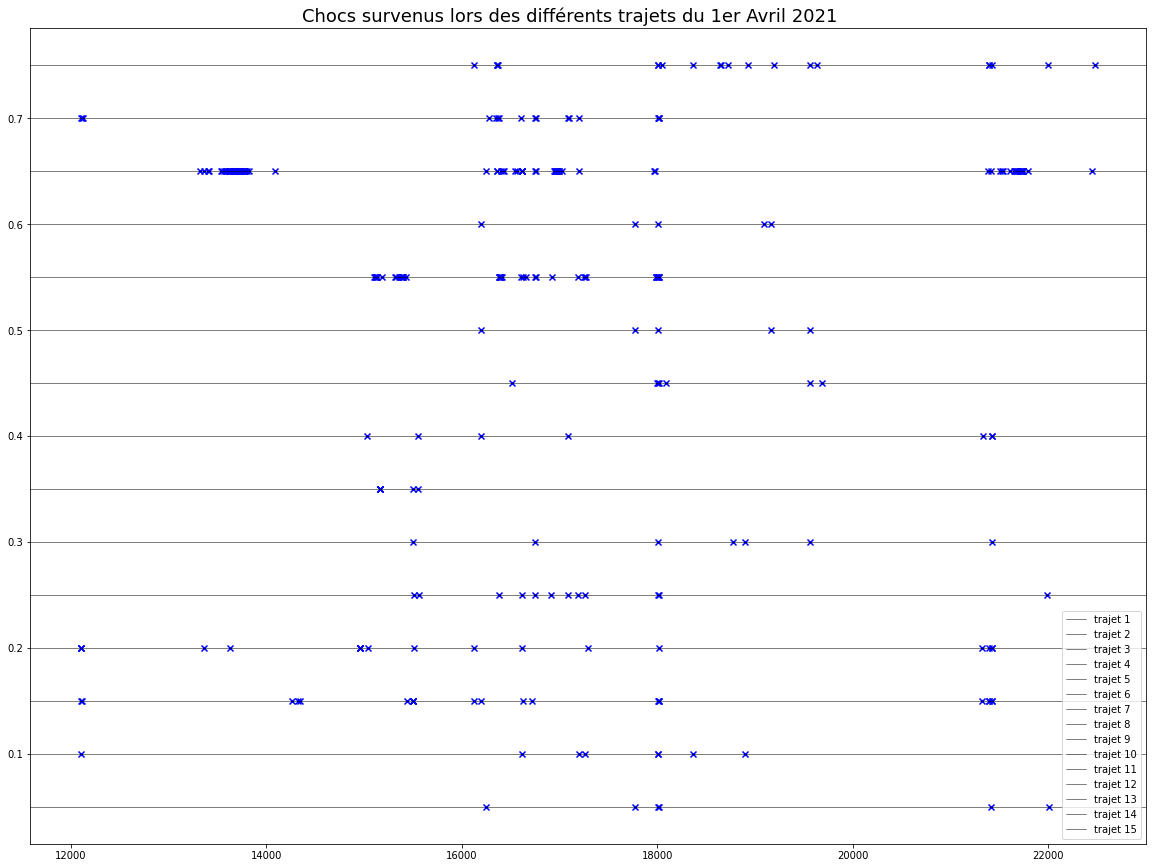

In [428]:
plt.figure(figsize=(20,len(days[0])))
plt.subplots_adjust(hspace=1.5)
plt.suptitle("Chocs survenus lors des différents trajets du 1er Avril 2021", fontsize=18, y=0.90)

trajets_jour1 = []
ys = np.arange(len(days[0])*0.05,0,-0.05)

for i in range(len(days[0])):
    trajet_i = id_serie_to_shocks[days[0][i]].reset_index(drop=True) #on récupère le trajet
    clustering = DBSCAN(eps=10, min_samples=1,metric='euclidean',algorithm = 'auto') #dbscan eps=10,min_sample=1
    clustering.fit(trajet_i[['pk']].to_numpy().reshape(-1,1))
    trajet_i['clusterlabs']=clustering.labels_ #On ajoute les labels des chocs du trajet considéré.
    
    #on récupère les dfs de chaque trajet, au cas où l'on voudrait regarder les labels pour être sûrs :
    trajets_jour1.append(trajet_i[['pk','clusterlabs']]) 
    
    plt.scatter(trajet_i[['pk']].to_numpy(), y=np.repeat(ys[i],len(trajet_i)),
            color="blue",
            #c = trajet_i['clusterlabs'].astype(float),
            #cmap = Paired_12.mpl_colormap,
            marker = 'x')
    plt.axhline(y=ys[i], linewidth = 0.5, color='black', label = f'trajet {i+1}')
    #for j in range(len(trajet_i)):
     #   plt.axvline(trajet_i['pk'][j],color='skyblue',alpha=0.5)
    plt.legend()
plt.savefig('chocs_jour_1.png')

In [431]:
# On peut accèder aux trajets et au groupe formés comme suit
# trajets_jour1[0] #pour le trajet n°1

+ On a pour intuition que si, au fur et à mesure des trajets, des chocs sont enregistrés à un même endroit ou à des endroits très proches, alors ils sont dûs à un probable défaut de voie.  

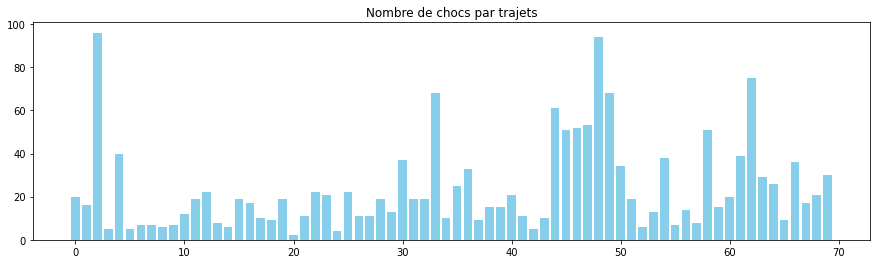

In [287]:
plt.figure(figsize = (15,4))
plt.title("Nombre de chocs par trajets")
plt.bar(np.arange(0,70,1),[len(id_serie_to_shocks[id_serie_list[i]]) for i in range(70)],color='skyblue');

+ On remarque également qu'un nombre très élevé de chocs a été enregistré lors de certains trajets, pourtant tous de direction PANLAP et sur la même voie. Il est légitime de se demander si ces enregistrements n'aurait pas été compromis par un défaut de l'appareil, un freinage brusque etc...

$\Rightarrow$ On souhaite donc effectuer un premier tri des chocs, en retirant ceux qui ne se répètent pas au fur et à mesure des trajets, et ceux dont les trajets ont enregistrés un nombre anormal de chocs (ce qui pourrait venir biaiser notre étude).

Clustering de tous les chocs enregistrés sur une journée : 

In [414]:
# Création d'une liste de 5 dataframe. 
# Chaque dataframe contient les chocs enregistrés pour les journées du 1 au 5 Avril 2021
shocks_by_day = []
for i in range(5):
    dayshocks = []
    for j in range(len(days[i])):
        dayshocks.append(id_serie_to_shocks[days[i][j]].reset_index(drop=True))
    shocks_by_day.append(pd.concat(dayshocks).reset_index(drop=True))

In [415]:
#Chocs du 1er Avril 2021 :
choc1 = shocks_by_day[0]
len(choc1)
#clusteringday1 = DBSCAN(eps=10, min_samples=3,metric='euclidean',algorithm = 'auto').fit(choc1[['pk']].to_numpy().reshape(-1,1))

276

In [416]:
idx = [np.where(choc1['pk'] == pk) for pk in id_serie_to_shocks[days[0][2]]['pk'].tolist()]
idx2 = [np.where(choc1['pk'] == pk) for pk in id_serie_to_shocks[days[0][4]]['pk'].tolist()]

In [417]:
indx = list(range(idx[0][0][0],idx[len(idx)-1][0][0]+1))
indx2 = list(range(idx2[0][0][0],idx2[len(idx2)-1][0][0]+1))

choc1.drop(indx+indx2, axis=0, inplace=True)

In [418]:
print(len(choc1))
choc1

140


,timestamp,pk,sensor,direction,x,y,z,pk_merge_prev,speed_prec_merge_prev,speed_next_merge_prev,pk_merge_next,speed_prec_merge_next,speed_next_merge_next,timeframe_gps_prev,timeframe_gps_next,average_speed_km_h_prev,average_speed_km_h_next,clusterlabs
0,2021-04-01 00:13:54.178,16128.006392,XXX_2,PANLAP,"[-0.39, -0.79, 0.51, 0.31, -0.29, 0.0099999999...","[0.246875, -0.653125, -2.353125, -1.353125, 0....","[-0.22625, -0.02625, -0.12625, 0.37375, -0.226...",16096.727550,6.903873,27.068229,16134.329831,27.068229,44.869984,4.160,0.841,27.068229,27.068229,0
1,2021-04-01 00:14:09.161,16356.841050,XXX_2,PANLAP,"[0.155, 1.155, 0.455, -0.34500000000000003, -0...","[0.325, -0.17500000000000002, -0.275, -0.07500...","[1.424375, 0.724375, 0.22437500000000002, -0.1...",16278.444100,58.889486,68.138344,16373.080689,68.138344,69.760655,4.142,0.858,68.138344,68.138344,1
2,2021-04-01 00:14:09.588,16364.923015,XXX_1,PANLAP,"[0.511875, 0.111875, 0.011875000000000004, -0....","[-0.881875, 0.018125000000000006, 0.318125, 1....","[0.23249999999999998, -0.8675, 0.0325, -0.5675...",16278.444100,58.889486,68.138344,16373.080689,68.138344,69.760655,4.569,0.431,68.138344,68.138344,1
3,2021-04-01 00:14:09.971,16372.172177,XXX_2,PANLAP,"[0.47125, 0.17125, -0.32875, 0.27125, -0.02875...","[-0.851875, 0.948125, 1.248125, 2.548125, 0.74...","[-0.6812499999999999, -1.08125, 0.31875, -0.18...",16278.444100,58.889486,68.138344,16373.080689,68.138344,69.760655,4.952,0.048,68.138344,68.138344,1
4,2021-04-01 00:15:34.629,18008.476951,XXX_1,PANLAP,"[-0.579375, 0.520625, 0.420625, 0.120625000000...","[-0.185, 0.11500000000000002, -0.7849999999999...","[-0.843125, 0.356875, 1.256875, 1.456875, -0.8...",17919.462059,69.667170,69.512714,18016.007495,69.512714,69.355828,4.610,0.390,69.512714,69.512714,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,2021-04-01 23:13:21.655,17775.240368,XXX_2,PANLAP,"[0.495, 0.995, 1.0950000000000002, -0.705, 0.2...","[-1.01125, 0.7887500000000001, 1.58875, 0.1887...","[0.7737499999999999, -2.72625, -3.12625, -3.92...",17748.289840,59.710578,59.159696,17830.456085,59.159696,59.319253,1.640,3.360,59.159696,59.159696,1
272,2021-04-01 23:13:35.822,18008.675968,XXX_2,PANLAP,"[-0.36250000000000004, -0.1625, 0.6375, -0.662...","[-1.07625, -1.2762499999999999, -0.67625, -0.5...","[-0.131875, 0.468125, -0.131875, -1.3318750000...",17995.339350,59.396698,59.494208,18077.986720,59.494208,59.283003,0.807,4.194,59.494208,59.494208,2
273,2021-04-01 23:13:36.227,18015.369067,XXX_2,PANLAP,"[0.23125, -4.06875, -1.06875, 0.13125, -1.6687...","[-2.029375, 13.070625, 4.070625, 4.470625, -0....","[-1.6243750000000001, 1.675625, 2.875625, 0.37...",17995.339350,59.396698,59.494208,18077.986720,59.494208,59.283003,1.212,3.789,59.494208,59.494208,2
274,2021-04-01 23:19:13.909,21419.964504,XXX_2,PANLAP,"[0.46375, -0.33625, 0.06375, -0.13625, 0.16375...","[-1.3587500000000001, -1.9587500000000002, -1....","[0.135, 0.835, 0.635, -0.565, -1.4649999999999...",21354.745933,51.499948,60.294519,21438.488320,60.294519,60.529042,3.894,1.106,60.294519,60.294519,3


In [419]:
clusteringday1 = DBSCAN(eps=10, min_samples=3,metric='euclidean',algorithm = 'auto').fit(choc1[['pk']].to_numpy().reshape(-1,1))
choc1['clusterlabs']= clusteringday1.labels_

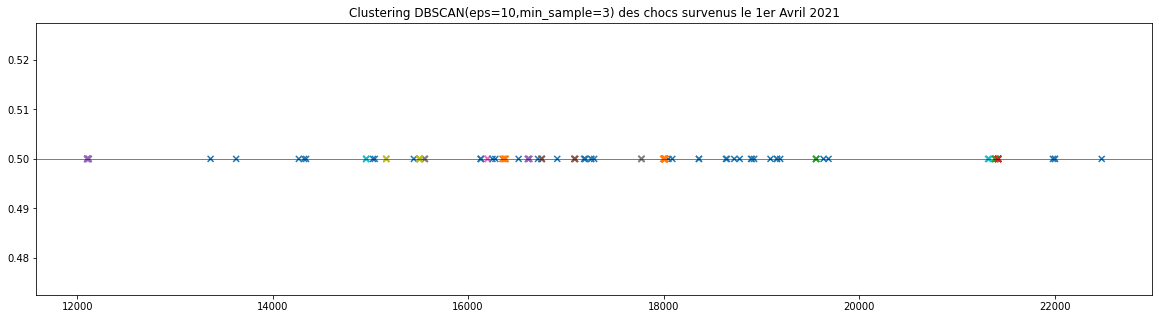

In [433]:
plt.figure(figsize=(20,5))

plt.title("Clustering DBSCAN(eps=10,min_sample=3) des chocs survenus le 1er Avril 2021")

plt.scatter(choc1[['pk']].to_numpy(), y=np.repeat(0.5,len(choc1)),
                c = choc1['clusterlabs'].astype(float),
            cmap = 'tab10',
            marker = 'x')
plt.axhline(y=0.5, linewidth = 0.5,color='black', label = 'track1')

In [432]:
print(set(choc1['clusterlabs'])) #17 groupes plus du bruit (groupe -1).
choc1[['pk','clusterlabs']]

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, -1}


,pk,clusterlabs
0,16128.006392,0
1,16356.841050,1
2,16364.923015,1
3,16372.172177,1
4,18008.476951,2
...,...,...
271,17775.240368,11
272,18008.675968,2
273,18015.369067,2
274,21419.964504,5


Retirons les pks associés au groupe -1 et voyons si les chocs qui ne se répètent pas au fur et à mesure des trajets ont bien été enlevés

In [437]:
gp_moins1 = choc1[['pk','clusterlabs']].loc[choc1['clusterlabs']== -1]
choc1.drop(list(gp_moins1.index), axis=0, inplace=True)

40
[6, 7, 8, 9, 10, 11, 12, 14, 18, 19, 23, 32, 135, 136, 180, 182, 186, 188, 189, 205, 206, 214, 216, 217, 220, 224, 225, 230, 234, 242, 243, 244, 245, 253, 264, 265, 268, 269, 270, 275]


On réeffectue le clustering : 

In [440]:
clusteringday1 = DBSCAN(eps=10, min_samples=3,metric='euclidean',algorithm = 'auto').fit(choc1[['pk']].to_numpy().reshape(-1,1))
choc1['clusterlabs']= clusteringday1.labels_

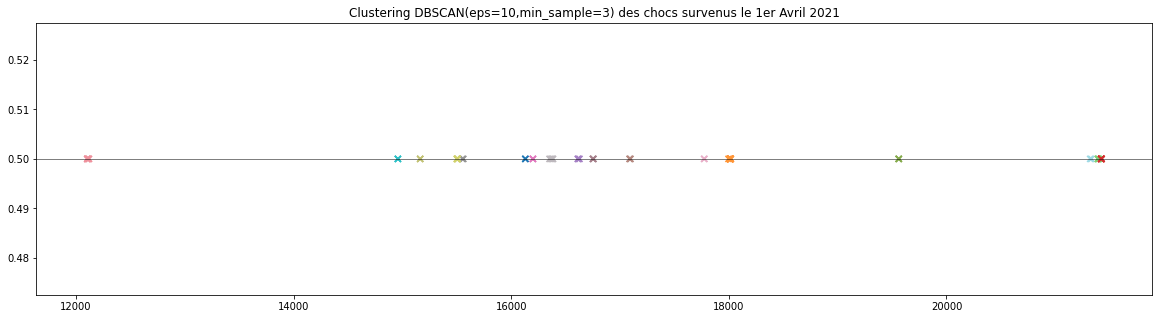

In [546]:
plt.figure(figsize=(20,5))

plt.title("Clustering DBSCAN(eps=10,min_sample=3) des chocs survenus le 1er Avril 2021")

plt.scatter(choc1[['pk']].to_numpy(), y=np.repeat(0.5,len(choc1)),
                c = choc1['clusterlabs'].astype(float),
            cmap = Tableau_20.mpl_colormap,
            marker = 'x')
plt.axhline(y=0.5, linewidth = 0.5,color='black', label = 'track1')

In [442]:
print(set(choc1['clusterlabs']))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}


On voit bien qu'il n'y a plus de bruit. Essayons maintenant de voir ce que ça donne si l'on sépare les chocs du jour 1 par trajets

On re-sépare les chocs du jours 1 grâce aux 2 cellules ci-dessous.

In [484]:
tr1idx_ = [np.where(choc1['pk'] == pk) for pk in id_serie_to_shocks[id_serie_list[0]]['pk'].tolist()]
tr2idx_ = [np.where(choc1['pk'] == pk) for pk in id_serie_to_shocks[id_serie_list[1]]['pk'].tolist()]
tr4idx_ = [np.where(choc1['pk'] == pk) for pk in id_serie_to_shocks[id_serie_list[3]]['pk'].tolist()]
tr6idx_ = [np.where(choc1['pk'] == pk) for pk in id_serie_to_shocks[id_serie_list[5]]['pk'].tolist()]
tr7idx_ = [np.where(choc1['pk'] == pk) for pk in id_serie_to_shocks[id_serie_list[6]]['pk'].tolist()]
tr8idx_ = [np.where(choc1['pk'] == pk) for pk in id_serie_to_shocks[id_serie_list[7]]['pk'].tolist()]
tr9idx_ = [np.where(choc1['pk'] == pk) for pk in id_serie_to_shocks[id_serie_list[8]]['pk'].tolist()]
tr10idx_ = [np.where(choc1['pk'] == pk) for pk in id_serie_to_shocks[id_serie_list[9]]['pk'].tolist()]
tr11idx_ = [np.where(choc1['pk'] == pk) for pk in id_serie_to_shocks[id_serie_list[10]]['pk'].tolist()]
tr12idx_ = [np.where(choc1['pk'] == pk) for pk in id_serie_to_shocks[id_serie_list[11]]['pk'].tolist()]
tr13idx_ = [np.where(choc1['pk'] == pk) for pk in id_serie_to_shocks[id_serie_list[12]]['pk'].tolist()]
tr14idx_ = [np.where(choc1['pk'] == pk) for pk in id_serie_to_shocks[id_serie_list[13]]['pk'].tolist()]
tr15idx_ = [np.where(choc1['pk'] == pk) for pk in id_serie_to_shocks[id_serie_list[14]]['pk'].tolist()]

In [496]:
tr1idx,tr2idx,tr4idx,tr6idx,tr7idx,tr8idx,tr9idx, = [],[],[],[],[],[],[],
tr10idx,tr11idx,tr12idx,tr13idx,tr14idx,tr15idx = [],[],[],[],[],[]


for i in range(len(tr1idx_)):
    if tr1idx_[i][0].shape[0] != 0:
        tr1idx.append(tr1idx_[i][0][0])
        
for i in range(len(tr2idx_)):
    if tr2idx_[i][0].shape[0] != 0:
        tr2idx.append(tr2idx_[i][0][0])
        
for i in range(len(tr4idx_)):
    if tr4idx_[i][0].shape[0] != 0:
        tr4idx.append(tr4idx_[i][0][0])

for i in range(len(tr6idx_)):
    if tr6idx_[i][0].shape[0] != 0:
        tr6idx.append(tr6idx_[i][0][0])
        
for i in range(len(tr7idx_)):
    if tr7idx_[i][0].shape[0] != 0:
        tr7idx.append(tr7idx_[i][0][0])
        
for i in range(len(tr8idx_)):
    if tr8idx_[i][0].shape[0] != 0:
        tr8idx.append(tr8idx_[i][0][0])
        
for i in range(len(tr9idx_)):
    if tr9idx_[i][0].shape[0] != 0:
        tr9idx.append(tr9idx_[i][0][0])
        
for i in range(len(tr10idx_)):
    if tr10idx_[i][0].shape[0] != 0:
        tr10idx.append(tr10idx_[i][0][0])
        
for i in range(len(tr11idx_)):
    if tr11idx_[i][0].shape[0] != 0:
        tr11idx.append(tr11idx_[i][0][0])
        
for i in range(len(tr12idx_)):
    if tr12idx_[i][0].shape[0] != 0:
        tr12idx.append(tr12idx_[i][0][0])
        
for i in range(len(tr13idx_)):
    if tr13idx_[i][0].shape[0] != 0:
        tr13idx.append(tr13idx_[i][0][0])
        
for i in range(len(tr14idx_)):
    if tr14idx_[i][0].shape[0] != 0:
        tr14idx.append(tr14idx_[i][0][0])
        
for i in range(len(tr15idx_)):
    if tr15idx_[i][0].shape[0] != 0:
        tr15idx.append(tr15idx_[i][0][0])


Les chocs du jours 1 par trajets sont stocké dans la liste de dataframe suivante :  

In [511]:
choc1_tr = [choc1.iloc[tr1idx],choc1.iloc[tr2idx],choc1.iloc[tr4idx],choc1.iloc[tr6idx],choc1.iloc[tr7idx],
            choc1.iloc[tr8idx],choc1.iloc[tr9idx],choc1.iloc[tr10idx],choc1.iloc[tr11idx],choc1.iloc[tr12idx],
            choc1.iloc[tr13idx],choc1.iloc[tr14idx],choc1.iloc[tr15idx]]

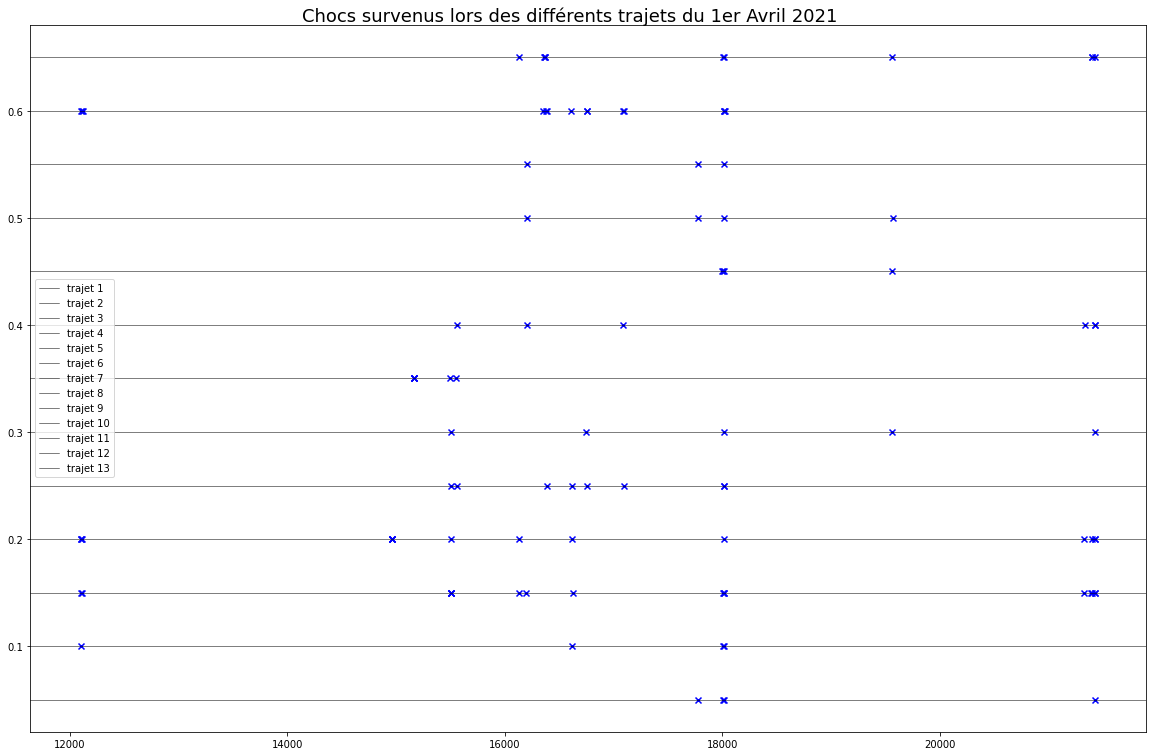

In [529]:
plt.figure(figsize=(20,len(choc1_tr)))
plt.subplots_adjust(hspace=1.5)
plt.suptitle("Chocs survenus lors des différents trajets du 1er Avril 2021", fontsize=18, y=0.90)

trajets_jour1_clean = []
ys = np.arange(len(choc1_tr)*0.05,0,-0.05)

for i in range(len(choc1_tr)):
    trajet_i = choc1_tr[i].reset_index(drop=True) #on récupère le trajet
    clustering = DBSCAN(eps=10, min_samples=1,metric='euclidean',algorithm = 'auto') #dbscan eps=10,min_sample=1
    clustering.fit(trajet_i[['pk']].to_numpy().reshape(-1,1))
    trajet_i['clusterlabs']=clustering.labels_ #On ajoute les labels des chocs du trajet considéré.
    
    #on récupère les dfs de chaque trajet, au cas où l'on voudrait regarder les labels pour être sûrs :
    trajets_jour1_clean.append(trajet_i[['pk','clusterlabs']]) 
    
    plt.scatter(trajet_i[['pk']].to_numpy(), y=np.repeat(ys[i],len(trajet_i)),
            color="blue",
            #c = trajet_i['clusterlabs'].astype(float),
            #cmap = Paired_12.mpl_colormap,
            marker = 'x')
    plt.axhline(y=ys[i], linewidth = 0.5, color='black', label = f'trajet {i+1}')
    #for j in range(len(trajet_i)):
     #   plt.axvline(trajet_i['pk'][j],color='skyblue',alpha=0.5)
    plt.legend()
plt.savefig('chocs_jour_1_clean.png')

In [536]:
centroids = choc1.groupby('clusterlabs')['pk'].mean()
mins = choc1.groupby('clusterlabs')['pk'].min()
maxs = choc1.groupby('clusterlabs')['pk'].max()

In [543]:
DBclusters = pd.concat([mins,centroids,maxs],axis=1)
DBclusters.columns = ['pk_min','centroid','pk_max']
DBclusters

,pk_min,centroid,pk_max
clusterlabs,,,
0,16128.006392,16129.841857,16130.792796
1,16350.861639,16369.538718,16383.733825
2,17995.461683,18011.234280,18019.820138
3,19558.655338,19561.264553,19563.114609
4,21389.663828,21394.578248,21398.703600
5,21419.964504,21423.038097,21426.652514
6,12102.823539,12109.207930,12120.374033
7,16610.742632,16618.118040,16628.074697
8,16749.900751,16752.459386,16756.717694


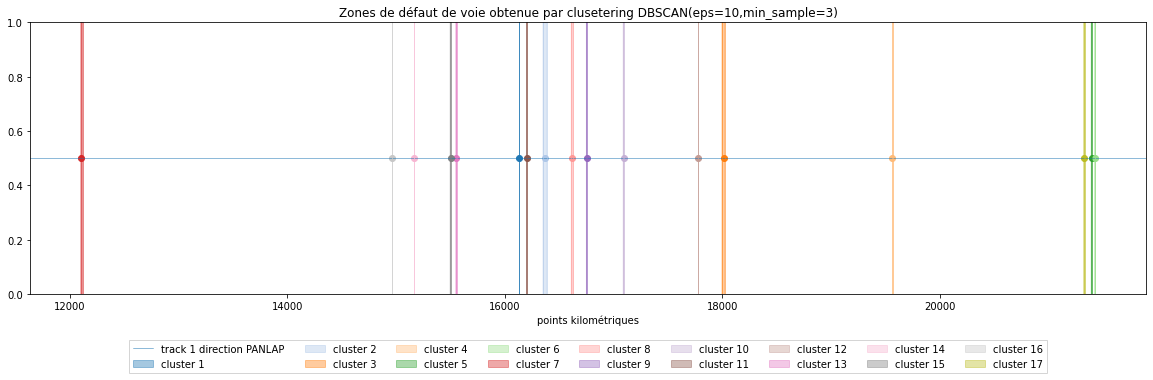

In [571]:
plt.figure(figsize=(20,5))
plt.title('Zones de défaut de voie obtenue par clusetering DBSCAN(eps=10,min_sample=3)')
plt.ylim([0,1])
plt.xlabel('points kilométriques')

plt.axhline(y=0.5,linewidth = 0.5, label = 'track 1 direction PANLAP')
for i in range(len(DBclusters)):
    plt.scatter(x = DBclusters.centroid[i],y=0.5,color = Tableau_20.mpl_colors[i])
    deb = DBclusters.pk_min[i]
    fin = DBclusters.pk_max[i]
    x = np.arange(deb, fin, 0.01)
    plt.axvline(x =deb,linewidth = 0.5,color=Tableau_20.mpl_colors[i])
    plt.axvline(x =fin,linewidth = 0.5,color=Tableau_20.mpl_colors[i])
    plt.fill_between(x, -1, 2,color=Tableau_20.mpl_colors[i],alpha=0.4,label=f'cluster {i+1}')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=False, shadow=False, ncol=9);
#plt.savefig('clustering_chocs_jour_1.png')

## Analyse du signal des chocs

Après avoir identifié les zones de probables défauts de voie, on se propose de compléter notre étude en analysant les signaux renvoyés par les chocs de nos différents clusters.  
Voici comment nous allons orienter notre étude :  

1. On se propose tout d'abord de calculer différentes métriques pour plusieurs signaux de chocs, et de regarder s'il y a une cohérence entre les métriques des chocs appartenant à un même cluster et une différence entre les chocs appartenant à deux clusters différents.
2. On se proposera ensuite, pour les chocs d'un seul cluster dans un premier temps, d'observer l'évolution des déplacement relatifs sur les 3 axes au fil des jours (jour 1, jour 2 etc...) afin de pouvoir caractériser la sévérité du choc

### 1. Comparaison des chocs
On décide de tenter de caractériser nos chocs par leurs pic d'accélération, la RMS de l'accélération, et le déplacement relatif de chaque axe (accélération intégrée 2 fois).

In [694]:
#voici les dataframes du jour 1 déjà regroupés par cluster
chocs1_by_groups = choc1.groupby('clusterlabs')[['timestamp','pk','clusterlabs','sensor','x','y','z']]
chocs1_by_groups.apply(display)

,timestamp,pk,clusterlabs,sensor,x,y,z
0,2021-04-01 00:13:54.178,16128.006392,0,XXX_2,"[-0.39, -0.79, 0.51, 0.31, -0.29, 0.0099999999...","[0.246875, -0.653125, -2.353125, -1.353125, 0....","[-0.22625, -0.02625, -0.12625, 0.37375, -0.226..."
232,2021-04-01 19:54:24.114,16130.726384,0,XXX_2,"[-0.9125, -0.0125, 0.1875, -0.1125, -0.2125000...","[1.4124999999999999, 0.6124999999999999, 0.312...","[-0.22875, 0.27125, 0.27125, -0.02875000000000..."
250,2021-04-01 21:00:27.156,16130.792796,0,XXX_2,"[-0.09, -0.09, -0.09, 0.010000000000000002, 0....","[0.774375, 0.774375, 0.774375, -0.525625, -1.8...","[-0.35187500000000005, 0.448125, -0.151875, -0..."


,timestamp,pk,clusterlabs,sensor,x,y,z
1,2021-04-01 00:14:09.161,16356.841050,1,XXX_2,"[0.155, 1.155, 0.455, -0.34500000000000003, -0...","[0.325, -0.17500000000000002, -0.275, -0.07500...","[1.424375, 0.724375, 0.22437500000000002, -0.1..."
2,2021-04-01 00:14:09.588,16364.923015,1,XXX_1,"[0.511875, 0.111875, 0.011875000000000004, -0....","[-0.881875, 0.018125000000000006, 0.318125, 1....","[0.23249999999999998, -0.8675, 0.0325, -0.5675..."
3,2021-04-01 00:14:09.971,16372.172177,1,XXX_2,"[0.47125, 0.17125, -0.32875, 0.27125, -0.02875...","[-0.851875, 0.948125, 1.248125, 2.548125, 0.74...","[-0.6812499999999999, -1.08125, 0.31875, -0.18..."
24,2021-04-01 01:21:15.464,16350.861639,1,XXX_2,"[-0.148125, -0.148125, -0.7481249999999999, 0....","[-2.2737499999999997, -4.37375, -2.57375, -0.4...","[-0.91, 0.49, 0.49, -0.31, -0.51, 0.59, 0.59, ..."
25,2021-04-01 01:21:16.678,16374.643433,1,XXX_2,"[0.77625, -0.22375, -0.22375, -0.22375, 0.0762...","[-1.8218750000000001, 1.1781249999999999, 2.77...","[-0.629375, -0.829375, -0.7293750000000001, -0..."
26,2021-04-01 01:21:17.135,16383.595888,1,XXX_1,"[0.395, -0.005, -0.305, -0.805, 0.095, -0.1050...","[0.68125, -0.21875, 0.28125, 0.481249999999999...","[1.6531250000000002, -1.3468749999999998, 0.25..."
211,2021-04-01 18:56:53.704,16383.733825,1,XXX_2,"[0.164375, 0.064375, 0.26437499999999997, -0.8...","[-1.845625, -0.245625, -0.645625, 1.554375, 1....","[-0.28562499999999996, 0.014375000000000006, 0..."


,timestamp,pk,clusterlabs,sensor,x,y,z
4,2021-04-01 00:15:34.629,18008.476951,2,XXX_1,"[-0.579375, 0.520625, 0.420625, 0.120625000000...","[-0.185, 0.11500000000000002, -0.7849999999999...","[-0.843125, 0.356875, 1.256875, 1.456875, -0.8..."
5,2021-04-01 00:15:34.746,18010.736114,2,XXX_2,"[-0.8456250000000001, 0.254375, 0.854375, 0.05...","[1.3099999999999998, 1.6099999999999999, -0.99...","[-0.61125, -1.31125, 1.78875, 0.48875, 0.88875..."
33,2021-04-01 01:22:41.316,18012.021986,2,XXX_2,"[0.113125, -0.48687499999999995, -0.686875, 0....","[-0.11125000000000002, 0.8887499999999999, 0.6...","[-0.18125, -0.78125, -0.08124999999999999, 1.0..."
34,2021-04-01 01:22:41.520,18015.949944,2,XXX_1,"[0.1925, -0.3075, 1.1925, 0.0925, -0.207500000...","[-0.905, 0.295, 0.695, 0.695, -0.2050000000000...","[-0.13187500000000002, 0.468125, 1.66812499999..."
35,2021-04-01 01:22:41.721,18019.820138,2,XXX_2,"[0.420625, 1.0206250000000001, 0.220625, -0.27...","[0.231875, -0.268125, 0.231875, 1.131875000000...","[0.1625, -1.6375, -1.4375, -0.2375, 0.1625, 2...."
134,2021-04-01 03:19:50.364,18012.436653,2,XXX_2,"[-0.50125, 0.09875, 0.39875000000000005, -0.50...","[-0.52625, -2.02625, -1.52625, 1.3737499999999...","[-0.6906249999999999, -0.490625, 1.009375, -0...."
179,2021-04-01 05:29:41.777,18009.332251,2,XXX_2,"[0.29874999999999996, -0.10125, 0.298749999999...","[2.3162499999999997, -0.28375, -2.183750000000...","[0.52, 0.31999999999999995, -0.38, -0.88, 1.02..."
183,2021-04-01 13:19:41.988,17995.461683,2,XXX_2,"[-0.516875, 0.183125, -0.216875, 0.38312500000...","[3.6550000000000002, 3.1550000000000002, 0.355...","[-0.055625, 0.944375, 1.044375, -0.055625, -0...."
184,2021-04-01 13:19:42.787,18008.515859,2,XXX_1,"[0.36062500000000003, 0.260625, 0.360625000000...","[-1.079375, 2.2206249999999996, 2.320624999999...","[-0.08062499999999999, -0.7806249999999999, -0..."
185,2021-04-01 13:19:43.202,18015.301301,2,XXX_2,"[0.84, -0.26, -0.46, 1.04, 1.54, -0.8600000000...","[2.47625, 2.27625, 1.7762499999999999, -0.5237...","[0.864375, 3.364375, 2.164375, -1.435625, -2.5..."


,timestamp,pk,clusterlabs,sensor,x,y,z
13,2021-04-01 00:17:43.943,19561.646724,3,XXX_2,"[-1.840625, 0.059375000000000004, 1.159375, -0...","[0.121875, -4.478125, -1.778125, 0.621875, 4.5...","[-0.23062499999999997, 1.069375, -2.030625, 0...."
181,2021-04-01 05:31:54.585,19563.114609,3,XXX_1,"[0.7837500000000001, 0.7837500000000001, -0.41...","[0.143125, -0.05687500000000001, -0.0568750000...","[-1.36375, 0.23625, 0.93625, 0.23625, 0.036250..."
187,2021-04-01 13:21:57.902,19561.641541,3,XXX_2,"[0.0275, -0.4725, 0.0275, 0.7274999999999999, ...","[0.904375, 0.904375, 0.404375, -3.195625, -0.5...","[0.34125000000000005, 0.44125000000000003, -0...."
207,2021-04-01 16:17:43.484,19558.655338,3,XXX_1,"[-1.0693750000000002, 0.8306250000000001, 0.03...","[2.086875, -0.9131250000000001, -0.613125, -0....","[0.483125, -1.716875, 0.083125, 0.383125000000..."


,timestamp,pk,clusterlabs,sensor,x,y,z
15,2021-04-01 00:20:49.011,21393.627289,4,XXX_1,"[-0.95625, -0.25625, 0.54375, -1.25625, 0.0437...","[-1.06875, -0.46875, -1.8687500000000001, -0.7...","[0.6806249999999999, -2.019375, -0.01937499999..."
16,2021-04-01 00:20:49.057,21394.387560,4,XXX_2,"[0.19312500000000002, -0.6068749999999999, -0....","[1.7975, 0.1975, -0.6024999999999999, -0.70249...","[-0.405, 0.395, 1.895, -0.005000000000000004, ..."
237,2021-04-01 20:01:34.575,21396.508965,4,XXX_1,"[0.15500000000000003, -0.8450000000000001, -0....","[0.16749999999999998, -2.0325, -2.2325, -1.532...","[0.35625, 0.65625, -0.44375000000000003, -0.34..."
258,2021-04-01 21:07:50.125,21389.663828,4,XXX_2,"[-0.561875, -0.16187500000000002, -0.661875, 0...","[0.18250000000000002, 2.6825, 1.4825, -0.01749...","[1.2037499999999999, 0.10375000000000001, -0.7..."
259,2021-04-01 21:07:50.688,21398.703600,4,XXX_1,"[0.01625, 0.21625, 0.21625, -0.383750000000000...","[0.95, 2.75, -1.55, -1.05, -1.45, -2.15, 0.25,...","[0.299375, 1.1993749999999999, 0.499375, -1.50..."


,timestamp,pk,clusterlabs,sensor,x,y,z
17,2021-04-01 00:20:50.646,21422.460800,5,XXX_1,"[0.5225, -0.4775, 0.5225, 0.7224999999999999, ...","[0.224375, -2.7756250000000002, -1.775625, -1....","[0.576875, -1.523125, 2.4768749999999997, -0.1..."
194,2021-04-01 14:26:05.656,21422.592413,5,XXX_1,"[0.39625000000000005, -0.40375, -0.30374999999...","[2.1350000000000002, 1.2349999999999999, -0.26...","[-0.9, -8.673617379884035e-19, 1.2, -1.8, -0.9..."
195,2021-04-01 14:26:05.903,21426.652514,5,XXX_2,"[-0.26437499999999997, -0.364375, 0.735625, 0....","[-2.7424999999999997, -1.2425, 0.2575, 1.9575,...","[0.31124999999999997, 0.41125, -0.28875, -0.58..."
208,2021-04-01 16:21:03.764,21423.507719,5,XXX_2,"[-0.209375, -0.609375, 0.890625, 0.19062500000...","[-0.6956249999999999, -1.6956250000000002, -1....","[-0.07062500000000001, 0.12937500000000002, 0...."
238,2021-04-01 20:01:36.045,21420.302964,5,XXX_2,"[-0.12312500000000001, -0.22312500000000002, 0...","[0.229375, 1.2293749999999999, 2.229375, 1.029...","[0.489375, 0.489375, -0.610625, -0.710625, 0.2..."
239,2021-04-01 20:01:36.213,21423.098852,5,XXX_1,"[-0.21625, -0.21625, 0.28375, 0.08375, -0.3162...","[0.6849999999999999, -0.515, -2.71500000000000...","[0.2775, 0.1775, 0.2775, 0.7775, 0.3775, -0.02..."
260,2021-04-01 21:07:52.148,21422.893743,5,XXX_2,"[0.13124999999999998, 0.13124999999999998, -0....","[0.761875, 0.161875, 0.661875, 0.461875, -1.23...","[-0.268125, -0.368125, 0.431875, -0.668125, 0...."
261,2021-04-01 21:07:52.326,21425.869367,5,XXX_1,"[0.4975, -0.3025, -0.10250000000000001, 0.1975...","[0.03437499999999999, 0.9343750000000001, -1.6...","[-0.11, 0.19000000000000003, -0.00999999999999..."
274,2021-04-01 23:19:13.909,21419.964504,5,XXX_2,"[0.46375, -0.33625, 0.06375, -0.13625, 0.16375...","[-1.3587500000000001, -1.9587500000000002, -1....","[0.135, 0.835, 0.635, -0.565, -1.4649999999999..."


,timestamp,pk,clusterlabs,sensor,x,y,z
20,2021-04-01 01:10:35.653,12103.529972,6,XXX_2,"[0.49625, -0.70375, -0.10375000000000001, 0.79...","[-0.05875000000000001, -0.15875, -0.75875, -1....","[-1.031875, 0.268125, 0.668125, -0.13187500000..."
21,2021-04-01 01:10:36.463,12117.466325,6,XXX_2,"[-0.35375, -0.053750000000000006, -0.75375, 0....","[0.374375, -0.02562499999999998, -1.025625, -0...","[-1.108125, -0.608125, 2.7918749999999997, 1.6..."
22,2021-04-01 01:10:36.632,12120.374033,6,XXX_1,"[1.4206249999999998, -0.079375, -0.979375, -0....","[-3.428125, -3.728125, -2.728125, -0.528125, 2...","[0.16125, 0.96125, -0.13875, 0.96125, -1.13875..."
221,2021-04-01 19:48:43.234,12102.823539,6,XXX_2,"[0.0037500000000000007, 0.30374999999999996, -...","[2.828125, 0.42812500000000003, 0.328125, -2.7...","[0.674375, 1.374375, -0.325625, -0.525625, -0...."
222,2021-04-01 19:48:43.336,12104.585724,6,XXX_1,"[-0.135625, 0.564375, 2.464375, -0.235625, 1.7...","[-2.7581249999999997, -4.758125000000001, -1.9...","[2.795625, -1.304375, -0.904375, -2.904375, -3..."
223,2021-04-01 19:48:43.638,12109.803173,6,XXX_2,"[0.7062499999999999, -1.1937499999999999, -0.8...","[3.02, -0.28, 0.8200000000000001, 4.02, -2.18,...","[-1.36125, -0.86125, 1.03875, 0.13875, 1.63875..."
240,2021-04-01 20:54:17.369,12107.048661,6,XXX_2,"[-0.085625, -0.285625, -0.185625, 1.014375, 0....","[-1.690625, -2.1906250000000003, -0.3906250000...","[0.304375, -0.19562500000000002, 1.704375, -0...."
241,2021-04-01 20:54:17.774,12114.161754,6,XXX_2,"[0.0031249999999999984, 0.303125, -1.996875, 1...","[8.4025, 5.2025, 6.9025, 0.8025, -12.2975, -1....","[2.580625, 0.380625, -0.8193750000000001, -1.7..."
262,2021-04-01 22:00:52.232,12103.078189,6,XXX_2,"[0.6224999999999999, 0.022500000000000003, -0....","[1.541875, 0.841875, 1.141875, -1.058125, -2.9...","[-1.8356249999999998, 0.7643749999999999, 0.46..."


,timestamp,pk,clusterlabs,sensor,x,y,z
27,2021-04-01 01:21:28.824,16610.742632,7,XXX_2,"[0.461875, 0.461875, -0.6381249999999999, -0.6...","[2.1568750000000003, 0.656875, -0.343125, 0.35...","[0.9325, -0.7675000000000001, -0.0675, -0.2674..."
212,2021-04-01 18:57:08.015,16620.755367,7,XXX_1,"[0.500625, -0.999375, 0.300625, 0.500625, -0.2...","[-1.3243749999999999, 0.275625, -0.52437499999...","[1.0593750000000002, -0.040625, -0.140625, -1...."
233,2021-04-01 19:54:55.284,16614.252746,7,XXX_2,"[0.72375, -0.5762499999999999, 0.02375, 0.1237...","[-0.41625, 1.3837499999999998, 2.38375, 2.5837...","[0.153125, -0.846875, 0.053125000000000006, -0..."
252,2021-04-01 21:00:59.137,16628.074697,7,XXX_2,"[0.335625, 0.335625, 0.7356250000000001, 0.035...","[0.45125000000000004, -0.44875, 1.55125, 2.051...","[0.39875000000000005, 0.69875, -1.00125, -0.90..."
263,2021-04-01 22:07:53.333,16616.764756,7,XXX_1,"[0.38625000000000004, -0.31375, -0.41375, 0.78...","[-1.69, 1.51, 2.11, 0.81, 0.41000000000000003,...","[-1.3924999999999998, -1.1925, 0.0074999999999..."


,timestamp,pk,clusterlabs,sensor,x,y,z
28,2021-04-01 01:21:36.115,16751.480164,8,XXX_2,"[-0.165, 0.135, -0.665, -0.165, 0.534999999999...","[0.11, 0.21000000000000002, -0.090000000000000...","[1.46, 1.26, 0.36, 0.06, -1.54, -2.73999999999..."
29,2021-04-01 01:21:36.387,16756.717694,8,XXX_1,"[0.306875, -0.393125, -0.393125, -0.2931249999...","[0.017499999999999998, -0.4825, -0.9825, 0.317...","[0.14125000000000001, 0.44125000000000003, 0.1..."
203,2021-04-01 16:14:13.302,16749.900751,8,XXX_2,"[0.18875, 0.48875, 0.18875, -0.01125, -0.51125...","[-2.52, -1.12, 1.88, 1.48, 1.38, 0.18000000000...","[0.58875, 0.08875000000000001, -1.31125, -0.01..."
213,2021-04-01 18:57:15.968,16751.738937,8,XXX_2,"[0.25687499999999996, 0.656875, -0.04312500000...","[-1.014375, -2.4143749999999997, 0.385625, 1.6...","[0.6875, -0.1125, -0.21250000000000002, -0.612..."


,timestamp,pk,clusterlabs,sensor,x,y,z
30,2021-04-01 01:21:53.533,17087.701659,9,XXX_2,"[0.40125, -0.19875, 0.20125, -0.29875, 0.30124...","[3.705, 0.405, 0.505, 1.905, -4.995, -0.795, 0...","[0.298125, -2.2018750000000002, 0.698125, -0.5..."
31,2021-04-01 01:21:54.002,17096.783250,9,XXX_1,"[1.626875, 0.626875, -0.473125, 0.826875, -0.1...","[1.026875, -2.073125, -0.37312500000000004, -1...","[-2.5275, 0.27249999999999996, 0.9725, 0.17250..."
192,2021-04-01 14:19:40.060,17087.912781,9,XXX_2,"[0.080625, -0.419375, 0.480625, -0.719375, 0.2...","[1.5756249999999998, 4.875625, 2.875625, 0.275...","[-0.245, -0.245, 0.655, 0.155, 0.155, -0.245, ..."
215,2021-04-01 18:57:36.616,17092.363738,9,XXX_2,"[-0.258125, 1.041875, 0.041875, -1.858125, 0.8...","[0.4, 3.9999999999999996, 4.5, 0.8, -1.9000000...","[-0.5187499999999999, -1.51875, -0.11875000000..."


,timestamp,pk,clusterlabs,sensor,x,y,z
132,2021-04-01 03:18:00.607,16199.948788,10,XXX_2,"[0.66375, 0.96375, -0.33625, -0.73625, 0.56375...","[1.98625, -0.11375000000000002, 0.78625, 0.486...","[-2.03625, 0.06375, 1.76375, 0.66375, 1.26375,..."
177,2021-04-01 05:27:52.052,16199.598490,10,XXX_2,"[-0.20625000000000002, -0.20625000000000002, 0...","[1.1243750000000001, 0.424375, 0.524375, -1.07...","[-0.38375000000000004, 0.21625, -0.68375, -0.0..."
191,2021-04-01 14:18:45.851,16199.338663,10,XXX_2,"[-0.5349999999999999, -0.235, 0.76499999999999...","[-0.22875, 0.6712499999999999, 0.8712500000000...","[-0.18000000000000002, 0.8200000000000001, 1.4..."
251,2021-04-01 21:00:32.823,16197.853654,10,XXX_2,"[0.89125, -0.30874999999999997, -0.40875, 0.39...","[-1.05, -0.6499999999999999, -0.64999999999999...","[0.10375000000000001, -0.09625, -0.19625, 0.60..."


,timestamp,pk,clusterlabs,sensor,x,y,z
133,2021-04-01 03:19:35.781,17771.301484,11,XXX_2,"[0.10187500000000001, -0.7981250000000001, 0.3...","[0.238125, 2.538125, 2.438125, 0.538125, -1.16...","[-0.801875, -0.20187500000000003, -0.101875000..."
178,2021-04-01 05:29:27.608,17775.014170,11,XXX_2,"[1.2293749999999999, 0.229375, -0.570624999999...","[-0.08187500000000002, 0.118125, 0.118125, -0....","[-3.06875, -3.16875, -0.76875, 2.93125, 2.9312..."
271,2021-04-01 23:13:21.655,17775.240368,11,XXX_2,"[0.495, 0.995, 1.0950000000000002, -0.705, 0.2...","[-1.01125, 0.7887500000000001, 1.58875, 0.1887...","[0.7737499999999999, -2.72625, -3.12625, -3.92..."


,timestamp,pk,clusterlabs,sensor,x,y,z
190,2021-04-01 14:17:24.935,15557.737784,12,XXX_2,"[-0.39687500000000003, -0.496875, 0.0031249999...","[-0.883125, -1.283125, -2.183125, 0.916875, 3....","[0.11125000000000002, -0.88875, 0.41125, 0.311..."
201,2021-04-01 15:11:08.828,15549.283121,12,XXX_2,"[0.45062500000000005, -0.24937499999999999, -0...","[-0.07375, 0.82625, 0.42625, 2.42625, -0.57375...","[1.26875, 0.16875, -0.93125, -0.13125, 0.46875..."
210,2021-04-01 18:55:11.667,15559.363958,12,XXX_2,"[0.579375, -0.420625, -0.420625, 0.979375, 0.9...","[-2.094375, -0.39437500000000003, 0.2056250000...","[0.6862499999999999, 0.6862499999999999, -0.61..."


,timestamp,pk,clusterlabs,sensor,x,y,z
196,2021-04-01 15:10:45.349,15163.358015,13,XXX_2,"[-0.135625, 0.16437500000000002, -0.535625, -0...","[-3.0900000000000003, -2.5900000000000003, 0.7...","[-0.11875000000000001, -0.31875, -0.21875, -0...."
197,2021-04-01 15:10:45.349,15163.358015,13,XXX_2,"[-0.135625, 0.16437500000000002, -0.535625, -0...","[-3.0900000000000003, -2.5900000000000003, 0.7...","[-0.11875000000000001, -0.31875, -0.21875, -0...."
198,2021-04-01 15:10:45.349,15163.358015,13,XXX_2,"[-0.135625, 0.16437500000000002, -0.535625, -0...","[-3.0900000000000003, -2.5900000000000003, 0.7...","[-0.11875000000000001, -0.31875, -0.21875, -0...."
199,2021-04-01 15:10:45.349,15163.358015,13,XXX_2,"[-0.135625, 0.16437500000000002, -0.535625, -0...","[-3.0900000000000003, -2.5900000000000003, 0.7...","[-0.11875000000000001, -0.31875, -0.21875, -0...."


,timestamp,pk,clusterlabs,sensor,x,y,z
200,2021-04-01 15:11:05.590,15497.979314,14,XXX_2,"[-0.315625, -0.115625, -0.215625, -0.015624999...","[-3.2556249999999998, -0.455625, 0.144375, 1.6...","[0.180625, 0.480625, -0.419375, -0.21937500000..."
202,2021-04-01 16:11:12.378,15505.400911,14,XXX_2,"[-0.12250000000000001, 0.27749999999999997, -1...","[-0.1975, -0.3975, 0.5025, -0.7975000000000001...","[-0.721875, -0.521875, 0.978125, 1.178125, -0...."
209,2021-04-01 18:55:08.426,15507.769225,14,XXX_2,"[0.7174999999999999, 0.5175, 0.117500000000000...","[-0.949375, 3.050625, 2.550625, 1.750625, 1.15...","[-0.46437500000000004, -0.46437500000000004, -..."
231,2021-04-01 19:53:10.835,15507.353901,14,XXX_2,"[-0.025, 0.375, -0.625, 0.07500000000000001, 0...","[0.15687500000000001, -0.243125, -0.943125, -1...","[-0.6074999999999999, -0.1075, 0.9925, 0.3925,..."
246,2021-04-01 20:59:03.350,15504.005426,14,XXX_2,"[0.279375, 0.279375, -1.720625, 1.179374999999...","[-1.4049999999999998, 0.095, 0.595, 0.795, -0....","[0.39875000000000005, 1.19875, 0.99875, -1.201..."
247,2021-04-01 20:59:03.350,15504.005426,14,XXX_2,"[0.279375, 0.279375, -1.720625, 1.179374999999...","[-1.4049999999999998, 0.095, 0.595, 0.795, -0....","[0.39875000000000005, 1.19875, 0.99875, -1.201..."
248,2021-04-01 20:59:03.350,15504.005426,14,XXX_2,"[0.279375, 0.279375, -1.720625, 1.179374999999...","[-1.4049999999999998, 0.095, 0.595, 0.795, -0....","[0.39875000000000005, 1.19875, 0.99875, -1.201..."
249,2021-04-01 20:59:03.350,15504.005426,14,XXX_2,"[0.279375, 0.279375, -1.720625, 1.179374999999...","[-1.4049999999999998, 0.095, 0.595, 0.795, -0....","[0.39875000000000005, 1.19875, 0.99875, -1.201..."


,timestamp,pk,clusterlabs,sensor,x,y,z
226,2021-04-01 19:52:37.631,14958.326083,15,XXX_2,"[-0.174375, 0.42562500000000003, -0.174375, -1...","[1.83375, 1.53375, 0.033749999999999995, -1.16...","[-1.02125, -0.42125, 0.17875000000000002, 0.87..."
227,2021-04-01 19:52:37.631,14958.326083,15,XXX_2,"[-0.174375, 0.42562500000000003, -0.174375, -1...","[1.83375, 1.53375, 0.033749999999999995, -1.16...","[-1.02125, -0.42125, 0.17875000000000002, 0.87..."
228,2021-04-01 19:52:37.631,14958.326083,15,XXX_2,"[-0.174375, 0.42562500000000003, -0.174375, -1...","[1.83375, 1.53375, 0.033749999999999995, -1.16...","[-1.02125, -0.42125, 0.17875000000000002, 0.87..."
229,2021-04-01 19:52:37.631,14958.326083,15,XXX_2,"[-0.174375, 0.42562500000000003, -0.174375, -1...","[1.83375, 1.53375, 0.033749999999999995, -1.16...","[-1.02125, -0.42125, 0.17875000000000002, 0.87..."


,timestamp,pk,clusterlabs,sensor,x,y,z
193,2021-04-01 14:25:59.834,21331.740889,16,XXX_2,"[-0.87875, -0.7787499999999999, 0.52125, -0.57...","[-1.115, 1.885, 1.2850000000000001, 2.685, 2.9...","[-0.29312499999999997, -0.493125, -0.993125, -..."
236,2021-04-01 20:01:29.971,21325.152247,16,XXX_2,"[0.07875, -0.72125, 0.17875000000000002, 0.378...","[-0.975, -0.975, -1.5750000000000002, 0.025000...","[-0.553125, -1.253125, 1.546875, 0.246875, -3...."
257,2021-04-01 21:07:45.673,21319.375410,16,XXX_2,"[-0.16625, -0.46625, 0.53375, -0.0662499999999...","[-2.1700000000000004, 0.33, 0.0300000000000000...","[0.07875000000000001, -0.62125, 0.47875, 0.278..."


""


In [588]:
from ast import literal_eval

In [720]:
#Analyse des valeurs ponctuelles dans un premier temps
def day1_sig_analysis(s,window_size = 8): #160 points donc 140 valeurs
    
    x_s = np.array(literal_eval(choc1["x"][s]))
    y_s = np.array(literal_eval(choc1["y"][s]))
    z_s = np.array(literal_eval(choc1["z"][s]))
    
    # Acceleration peak
    peak_x_s = np.max(abs(x_s))
    peak_y_s = np.max(abs(y_s))
    peak_z_s = np.max(abs(z_s))
    
    # Global RMS Acceleration
    rms_x_s = np.sqrt((x_s**2).sum())
    rms_y_s = np.sqrt((y_s**2).sum())
    rms_z_s = np.sqrt((z_s**2).sum())
    
    # Windowed RMS Acceleration
    wrms_x_s = np.zeros(len(x_s))
    wrms_y_s = np.zeros(len(x_s))
    wrms_z_s = np.zeros(len(x_s))
    
    for i in range(1,len(x_s)):
        if i <= len(x_s)-window_size:
            start = i
            end = i + window_size
            wrms_x_s[i] = np.sqrt((x_s[start:end]**2).sum())
            wrms_y_s[i] = np.sqrt((y_s[start:end]**2).sum())
            wrms_z_s[i] = np.sqrt((z_s[start:end]**2).sum())
            
        else:
            break
            
    sigs = [x_s,y_s,z_s]
    peaks = [peak_x_s, peak_y_s, peak_z_s]
    RMS = [rms_x_s,rms_y_s,rms_z_s]
    wRMS = [wrms_x_s,wrms_y_s,wrms_z_s]
    
    return(sigs,peaks,RMS,wRMS)

In [725]:
def comparaison_chocs(A,B,window_size):
    sigs_A,peaks_A,rms_A,wrms_A = day1_sig_analysis(A,window_size)
    sigs_B,peaks_B,rms_B,wrms_B = day1_sig_analysis(B,window_size)
    
    fig, ((ax1,ax4),(ax2,ax5),(ax3,ax6)) = plt.subplots(3,2,figsize = (20,12))
    
    ax1.plot(sigs_A[0],color = 'blue',label = 'accélération')
    ax1.plot(wrms_A[0],color = 'skyblue',label = 'rms mobile')
    ax1.set_title(f"Accélération lors du choc {A} selon l'axe x. Peak = {round(peaks_A[0],2)}, RMS = {round(rms_A[0],2)}")
    ax1.legend()
    
    ax2.plot(sigs_A[1],color = 'red',label = 'accélération')
    ax2.plot(wrms_A[1],color = 'orange',label = 'rms mobile')
    ax2.set_title(f"Accélération lors du choc {A} selon l'axe y. Peak = {round(peaks_A[1],2)}, RMS = {round(rms_A[1],2)}")
    ax2.legend()
    
    ax3.plot(sigs_A[2],color = 'green',label = 'accélération')
    ax3.plot(wrms_A[2],color = 'lime',label = 'rms mobile')
    ax3.set_title(f"Accélération lors du choc {A} selon l'axe z. Peak = {round(peaks_A[2],2)}, RMS = {round(rms_A[2],2)}")
    ax3.legend()
    
    ax4.plot(sigs_B[0],color = 'blue',label = 'accélération')
    ax4.plot(wrms_B[0],color = 'skyblue',label = 'rms mobile')
    ax4.set_title(f"Accélération lors du choc {B} selon l'axe x. Peak = {round(peaks_B[0],2)}, RMS = {round(rms_B[0],2)}")
    ax4.legend()
    
    ax5.plot(sigs_B[1],color = 'red',label = 'accélération')
    ax5.plot(wrms_B[1],color = 'orange',label = 'rms mobile')
    ax5.set_title(f"Accélération lors du choc {B} selon l'axe y. Peak = {round(peaks_B[1],2)}, RMS = {round(rms_B[1],2)}")
    ax5.legend()
    
    ax6.plot(sigs_B[2],color = 'green',label = 'accélération')
    ax6.plot(wrms_B[2],color = 'lime',label = 'rms mobile')
    ax6.set_title(f"Accélération lors du choc {B} selon l'axe z. Peak = {round(peaks_B[2],2)}, RMS = {round(rms_B[2],2)}")
    ax6.legend()
    
    print(f"{A} est un choc du groupe {choc1.loc[A]['clusterlabs']} et {B} est un choc du groupe {choc1.loc[B]['clusterlabs']}")
    print(f"Différence des pics selon l'axe x : {round(abs(peaks_A[0]-peaks_B[0]),2)}, et différence des RMS selon l'axe x : {round(abs(rms_A[0]-rms_B[0]),2)}")
    print(f"Différence des pics selon l'axe y : {round(abs(peaks_A[1]-peaks_B[1]),2)}, et différence des RMS selon l'axe y : {round(abs(rms_A[1]-rms_B[1]),2)}")
    print(f"Différence des pics selon l'axe z : {round(abs(peaks_A[2]-peaks_B[2]),2)}, et différence des RMS selon l'axe z : {round(abs(rms_A[2]-rms_B[2]),2)}")

Lorsque les chocs appartiennent au même cluster :

0 est un choc du groupe 0 et 232 est un choc du groupe 0
Différence des pics selon l'axe x : 0.08, et différence des RMS selon l'axe x : 0.1
Différence des pics selon l'axe y : 0.07, et différence des RMS selon l'axe y : 1.88
Différence des pics selon l'axe z : 1.5, et différence des RMS selon l'axe z : 2.68


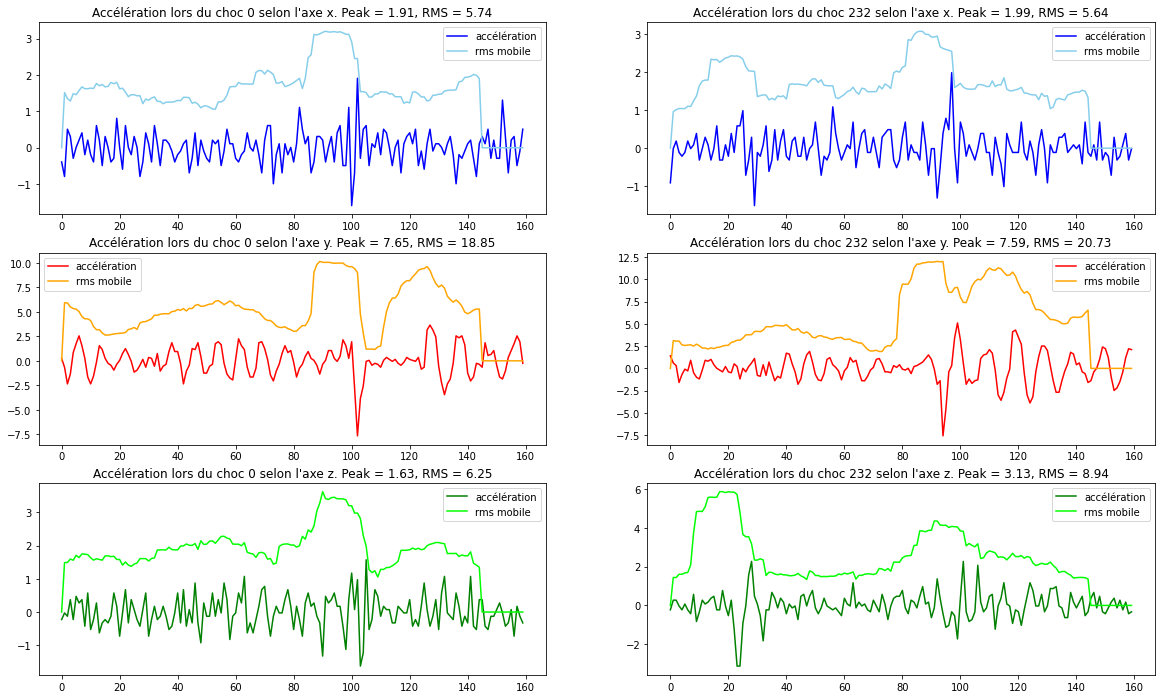

In [727]:
comparaison_chocs(0,232,window_size=16) #XXX_2

0 est un choc du groupe 0 et 250 est un choc du groupe 0
Différence des pics selon l'axe x : 0.32, et différence des RMS selon l'axe x : 0.07
Différence des pics selon l'axe y : 0.18, et différence des RMS selon l'axe y : 5.22
Différence des pics selon l'axe z : 0.12, et différence des RMS selon l'axe z : 1.34


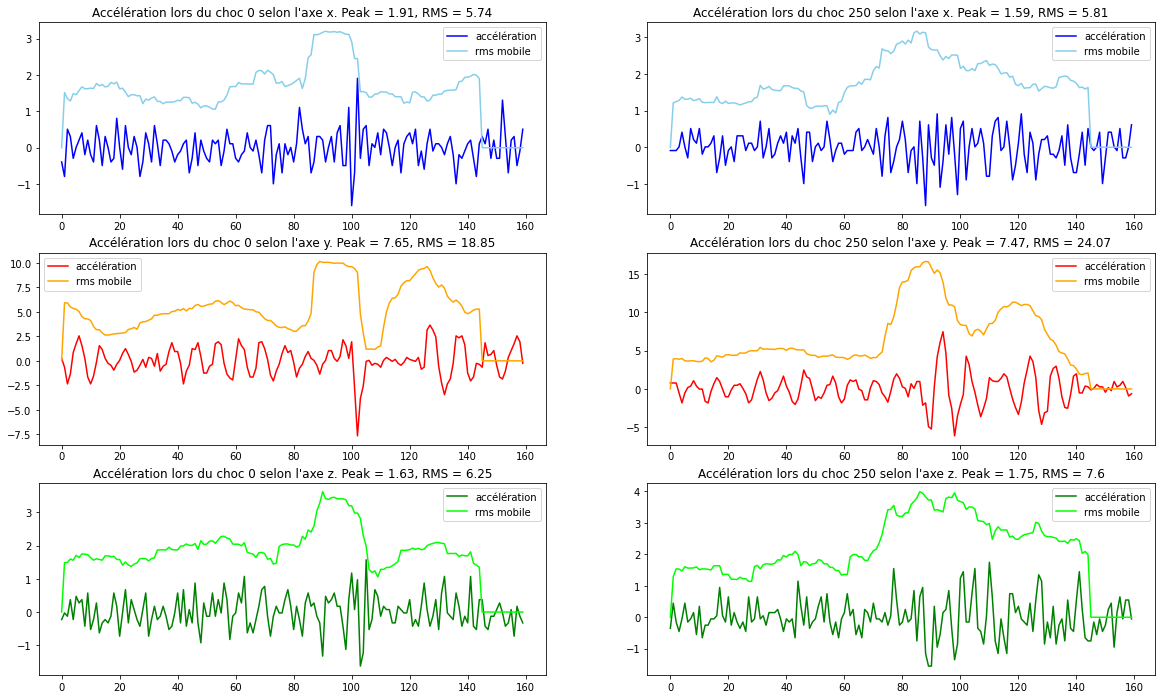

In [729]:
comparaison_chocs(0,250,window_size=16) #XXX_2

4 est un choc du groupe 2 et 34 est un choc du groupe 2
Différence des pics selon l'axe x : 1.03, et différence des RMS selon l'axe x : 1.78
Différence des pics selon l'axe y : 1.52, et différence des RMS selon l'axe y : 1.52
Différence des pics selon l'axe z : 1.41, et différence des RMS selon l'axe z : 6.71


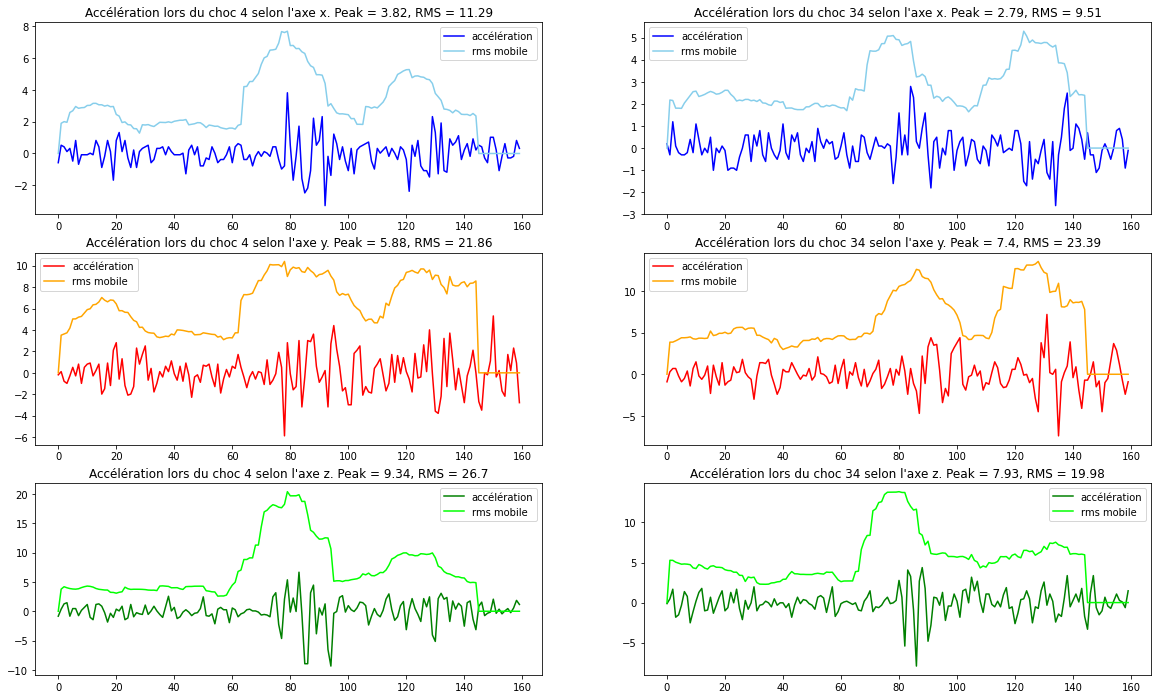

In [730]:
comparaison_chocs(4,34,window_size=16) #XXX_1

Lorsque les chocs de sont pas dans le même cluster :

0 est un choc du groupe 0 et 5 est un choc du groupe 2
Différence des pics selon l'axe x : 1.14, et différence des RMS selon l'axe x : 4.92
Différence des pics selon l'axe y : 1.64, et différence des RMS selon l'axe y : 3.85
Différence des pics selon l'axe z : 3.46, et différence des RMS selon l'axe z : 9.59


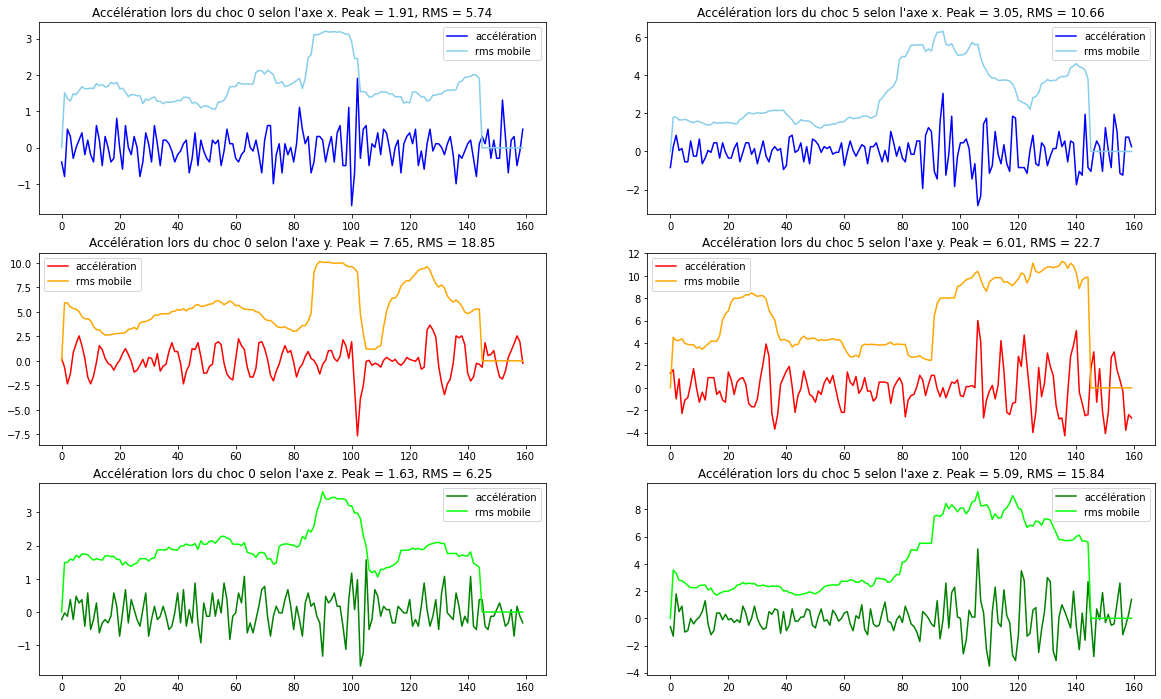

In [733]:
comparaison_chocs(0,5,window_size=16) #XXX_2

34 est un choc du groupe 2 et 15 est un choc du groupe 4
Différence des pics selon l'axe x : 0.65, et différence des RMS selon l'axe x : 0.71
Différence des pics selon l'axe y : 1.63, et différence des RMS selon l'axe y : 2.35
Différence des pics selon l'axe z : 3.65, et différence des RMS selon l'axe z : 4.35


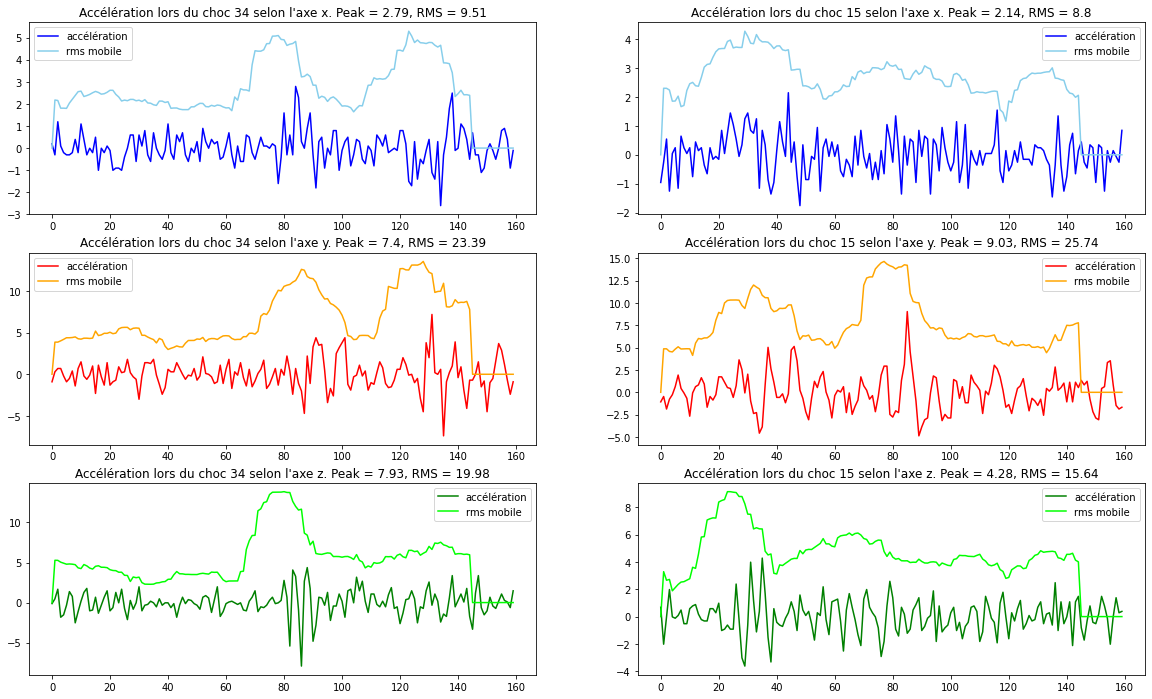

In [732]:
comparaison_chocs(34,15,window_size=16) #XXX_1

207 est un choc du groupe 3 et 15 est un choc du groupe 4
Différence des pics selon l'axe x : 0.33, et différence des RMS selon l'axe x : 0.62
Différence des pics selon l'axe y : 1.62, et différence des RMS selon l'axe y : 2.48
Différence des pics selon l'axe z : 1.7, et différence des RMS selon l'axe z : 1.46


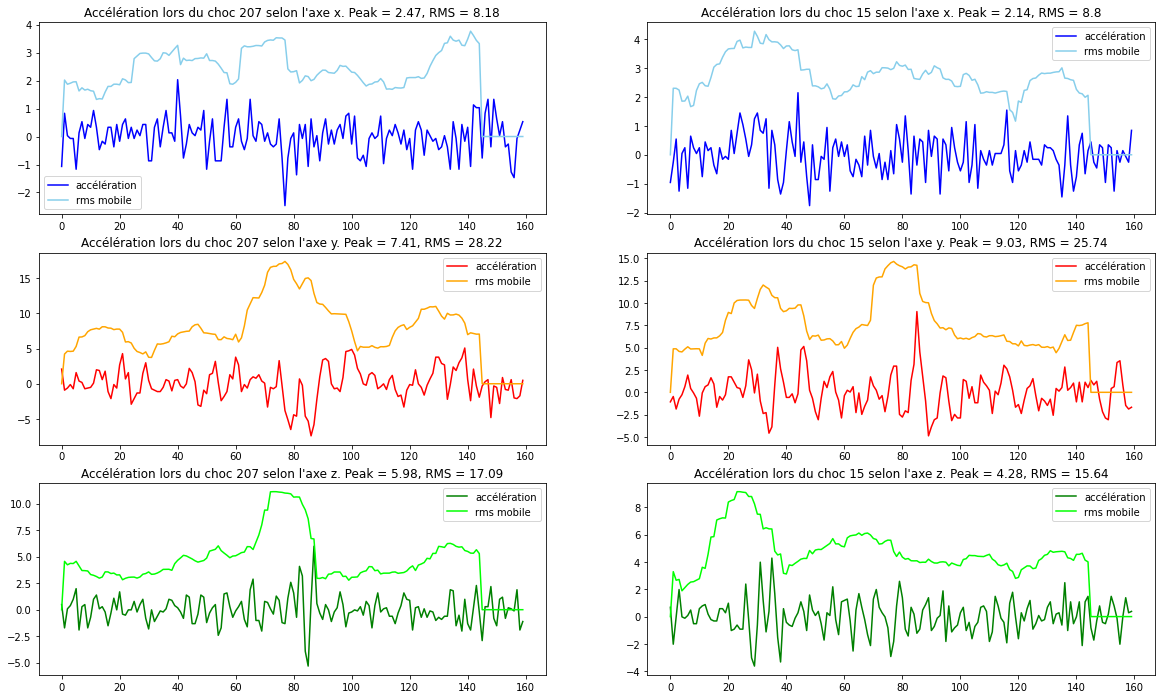

In [736]:
comparaison_chocs(207,15,window_size=16) #XXX_1

Après plusieurs comparaisons de chocs, soit appartenant au  même cluster, soit appartenant à des cluster différents, on constate que seule la RMSE mobile permet de caractériser correctement les accélération dûs à nos chocs
+ Lorsque les chocs proviennent du même cluster, on observe une certaine cohérence entre les courbe des rms mobiles.
+ Lorsque les chocs proviennent de deux cluster différents, il n'y a pas de cohérence ou alors peu entre ces courbes

### Déplacement relatif : 

In [681]:
from scipy.integrate import cumtrapz

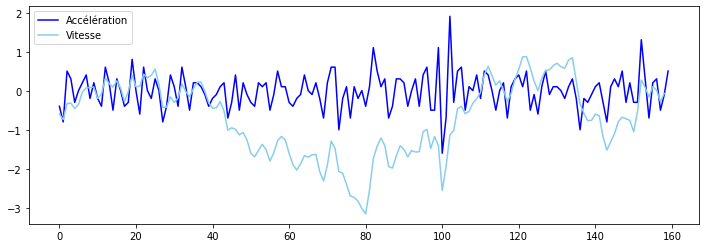

In [686]:
plt.figure(figsize=(12,4))
plt.plot(np.array(literal_eval(choc1["x"][0])), color='blue',label = 'Accélération')
plt.plot(cumtrapz(np.array(literal_eval(choc1["x"][0]))), color='skyblue',label = 'Vitesse')
plt.legend()

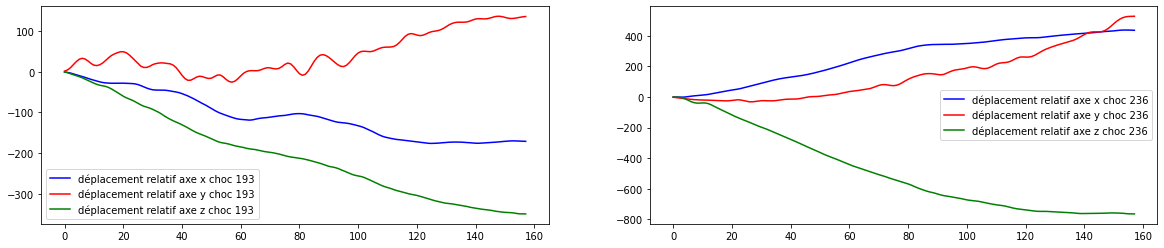

In [757]:
c = 193
c2 = 236
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,4))
ax1.plot(cumtrapz(cumtrapz(np.array(literal_eval(choc1["x"][c])))), color='blue',label = f"déplacement relatif axe x choc {c}")
ax1.plot(cumtrapz(cumtrapz(np.array(literal_eval(choc1["y"][c])))), color='red',label = f"déplacement relatif axe y choc {c}")
ax1.plot(cumtrapz(cumtrapz(np.array(literal_eval(choc1["z"][c])))), color='green',label = f"déplacement relatif axe z choc {c}")
ax1.legend()

ax2.plot(cumtrapz(cumtrapz(np.array(literal_eval(choc1["x"][c2])))), color='blue',label = f"déplacement relatif axe x choc {c2}")
ax2.plot(cumtrapz(cumtrapz(np.array(literal_eval(choc1["y"][c2])))), color='red',label = f"déplacement relatif axe y choc {c2}")
ax2.plot(cumtrapz(cumtrapz(np.array(literal_eval(choc1["z"][c2])))), color='green',label = f"déplacement relatif axe z choc {c2}")
ax2.legend();

Après l'étude des déplacements relatif provoqués par les chocs au sein des mêmes clusters, on peut caractériser un peu plus la nature des chocs :

- Cluster 0 impacte surtout l'axe des y
- Cluster 1 impacte surtout l'axe des x
- Cluster 2 impacte surtout l'axe des z et y
- Cluster 3 impacte surtout l'axe des y
- Cluster 4 impacte surtout l'axe des x et y
- Cluster 5 impacte surtout l'axe des y 
- Cluster 6 impacte surtout l'axe des x,y,z
- Cluster 7 impacte surtout l'axe des y et z
- Cluster 8 impacte surtout l'axe des x,y,z
- Cluster 9 impacte surtout l'axe des y 
- Cluster 10 impacte surtout l'axe des z et x
- Cluster 11 impacte surtout l'axe des x et y
- Cluster 12 impacte surtout l'axe des x 
- Cluster 13 impacte surtout l'axe des x et z
- Cluster 14 impacte surtout l'axe des y 
- Cluster 15 impacte surtout l'axe des y
- Cluster 16 impacte surtout l'axe des x,y,z

On aimerait maintenant répêter le clustering pour chaque jour, et effectuer des comparaisons de RMS mobile et de déplacement relatif des chocs au mêmes endroits (même cluster), mais à des jours différents.